<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Project 4 
## Web Scraping for Indeed.com and Predicting Salaries

## Stage 3: EDA and modelling


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme(context='notebook', style='darkgrid', palette='Set2', font_scale=1.5)

In [2]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

### EDA

In [3]:
# read in data
df = pd.read_csv('../GA/DSI15-project-submissions/Julia-McAleenan/project-4/jobs_clean.csv', index_col=0)
df.shape

(1914, 11)

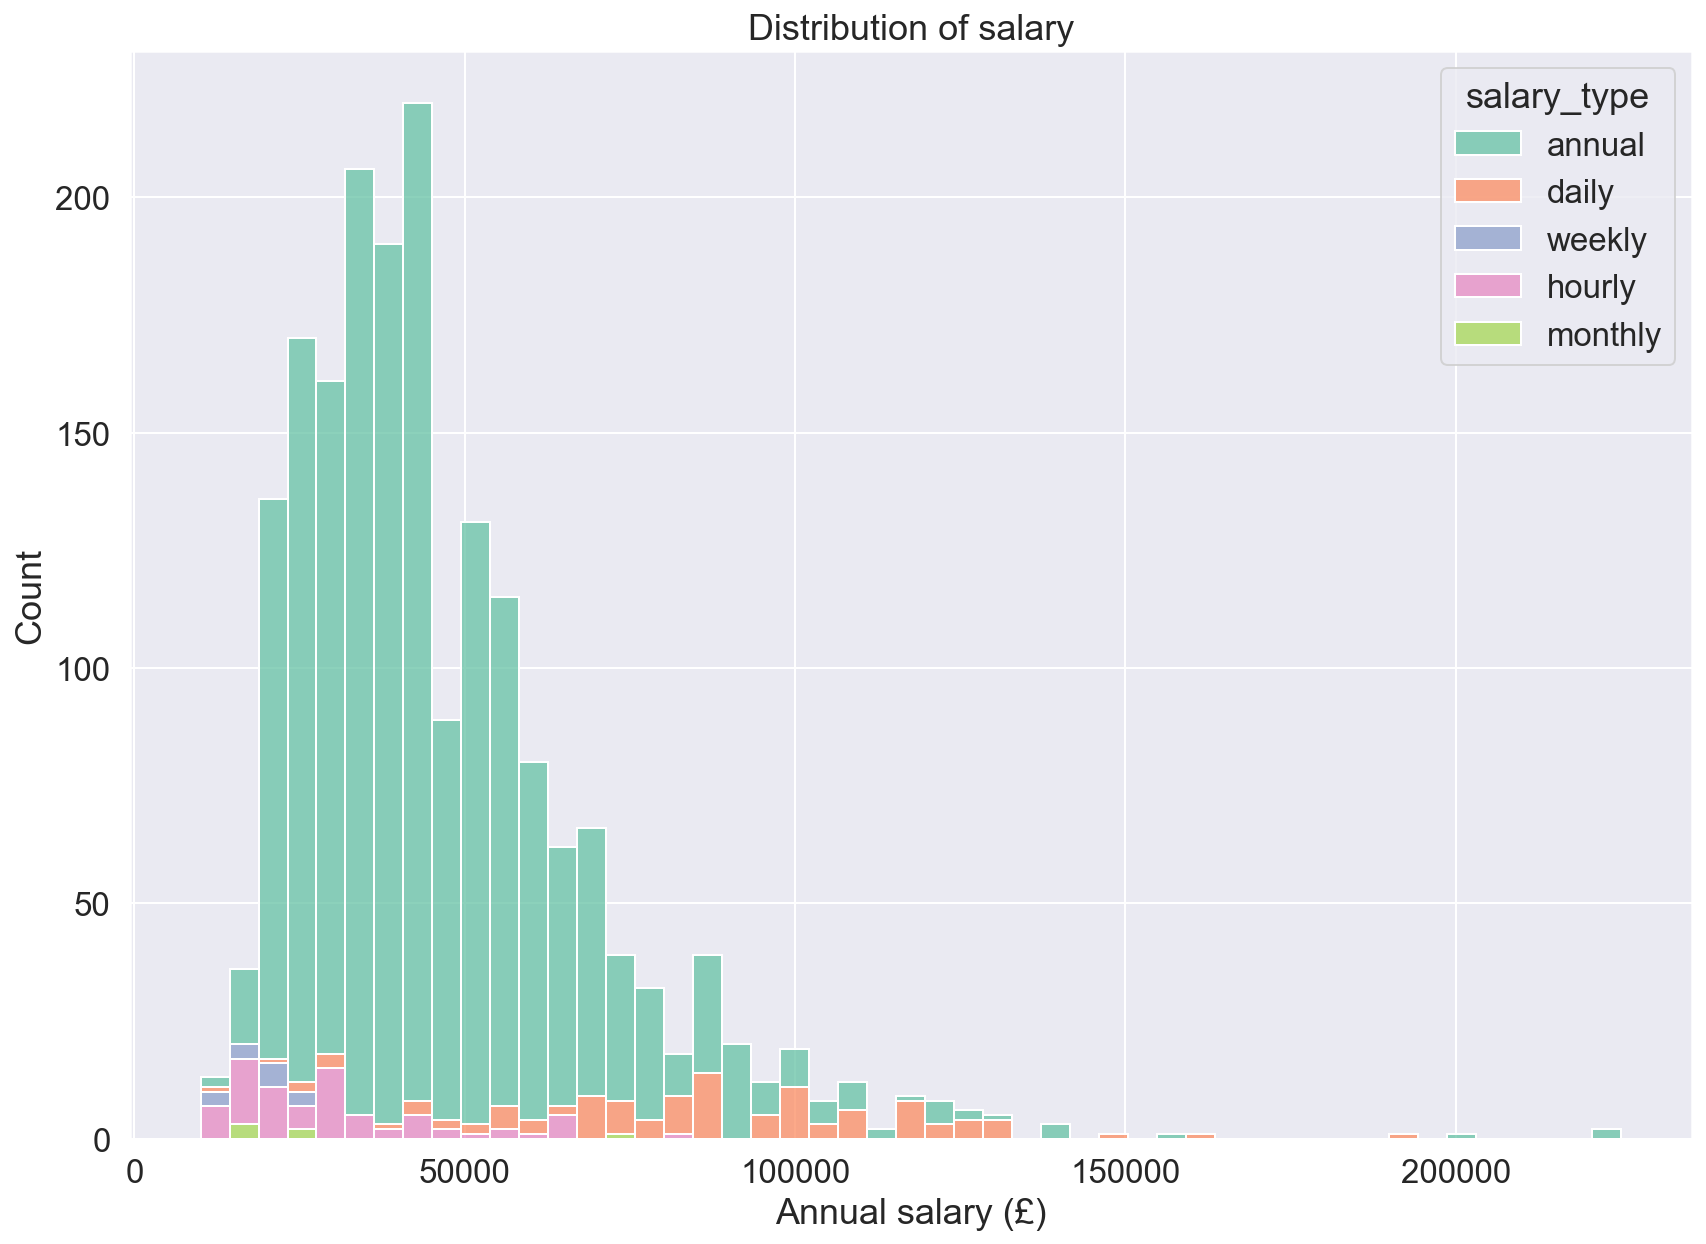

In [5]:
# plot annualised_salary
fig1, ax = plt.subplots(figsize=(14, 10))
sns.histplot(df, x='annualised_salary', ax=ax, hue='salary_type', multiple='stack')
ax.set_xlabel('Annual salary (£)')
ax.set_ylabel('Count')
ax.set_title('Distribution of salary')
plt.show()

#### Distribution of salary
The chart shows the distribution of the annual salary and includes information on how the salary is quoted in the job description e.g. is it quoted as an annual salary or as a daily rate (which I have converted to an annualized number for comparison). The distribution has positive skew i.e. most of the salaries are at the lower end with a few high values giving a long right tail.   

Unsurprisingly most of the salaries are quoted as annual salaries. It is interesting to see that the salaries which are quoted daily tend to be higher than the salaries which are quoted hourly, weekly or monthly. This implies that how the salary is quoted could be a good predictor of salary.

In [6]:
# check high salary instances
df[df.annualised_salary > 150000]

,company,location,job_title,salary,job_summary,company_rating,link,salary_type,annualised_salary,county,region
119,CRISIL LIMITED,London,Director - Data and Analytics –Financial Servi...,"£200,000 a year","Data architecture, data lineage, data quality ...",NaN,/company/CRISIL-LIMITED/jobs/Director-b1d3b85b...,annual,200000.0,Greater London,London
1070,People Source Consulting,London,"Enterprise Data Architect, Modeller, (73214567...",£700 - £750 a day,You can work with business and technology stak...,5.0,/rc/clk?jk=9268beda9dcc22b1&fccid=af65eb9722bf...,daily,159500.0,Greater London,London
1109,Hobson Prior,Slough,Head of Regulatory Affairs,"£150,000 - £160,000 a year","Accountable to Recruit, develop, and retain hi...",3.0,/rc/clk?jk=952479c805492b4e&fccid=e51b365cbd5f...,annual,155000.0,Berkshire,South East
1287,Michael Page UK,Birmingham,"Director, Cloud Implementation & Data Analytic...","£750 - £1,000 a day",Fundamental to the project will be the design ...,3.5,/rc/clk?jk=5389f1eb16e184aa&fccid=77087bd1709a...,daily,192500.0,West Midlands,West Midlands
1527,Thornshaw Scientific Recruitment,Cambridgeshire,Global Medical Director Digital Strategy and I...,"£225,000 a year","Salary$ 225,000 + Bonus, Car allowance, Long t...",NaN,/rc/clk?jk=6c615390fe8b50ec&fccid=c4492c8295ce...,annual,225000.0,Cambridgeshire,East
1637,UK Government Investments Ltd,London,"Director, Contingent Liabilities Group","£200,000 - £250,000 a year",The central capability will play a leading rol...,NaN,/pagead/clk?mo=r&ad=-6NYlbfkN0Cn4yrp7RuVgkI-qu...,annual,225000.0,Greater London,London


In [7]:
df.region.value_counts(normalize=True)

London                0.400209
South East            0.136886
West Midlands         0.099791
North West            0.086207
South West            0.057471
Yorkshire & Humber    0.053292
East                  0.041797
Scotland              0.029781
Remote                0.028213
North East            0.026123
East Midlands         0.026123
Wales                 0.014107
Name: region, dtype: float64

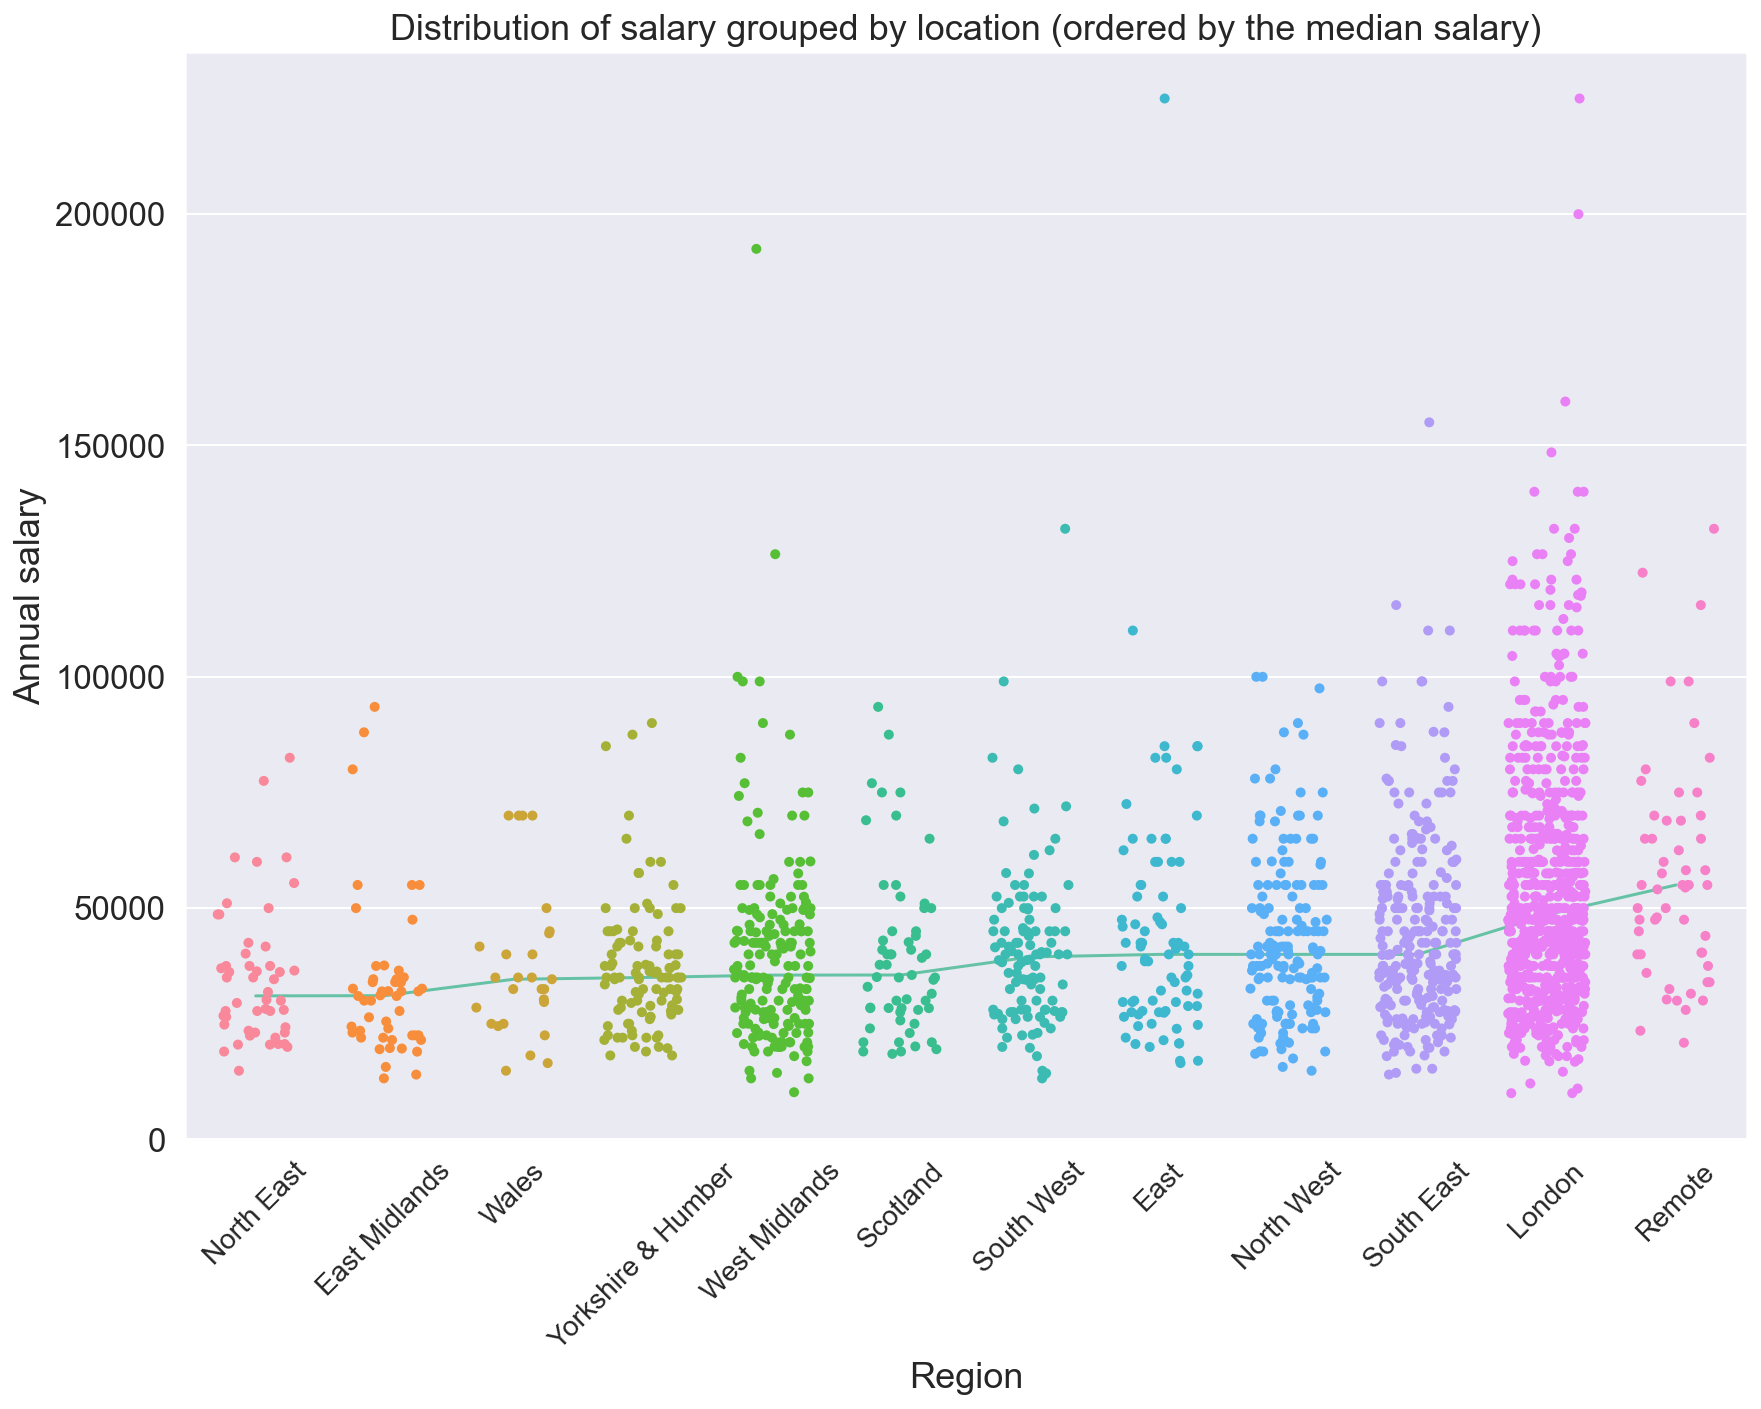

In [8]:
fig2, ax = plt.subplots(figsize=(14, 10))
plot_order = df.groupby('region').annualised_salary.median().sort_values().index
sns.stripplot(data=df, x='region', y='annualised_salary', order=plot_order, jitter=0.3)
sns.lineplot(y=df.groupby('region').annualised_salary.median().sort_values(),
             x=df.groupby('region').annualised_salary.median().sort_values().index)
plt.xticks(rotation=45, fontsize=14)
plt.ylim(0,235000)
plt.xlabel('Region')
plt.ylabel('Annual salary')
plt.title('Distribution of salary grouped by location (ordered by the median salary)')
plt.show()

#### Distribution of salary grouped by location
The chart shows the distribution of salary by region, ordered by the median salary by region (shown by the line). Unsurprisingly London has the most data points and the second highest median salary. Jobs advertised as 'remote' have the highest median salary but there are not many data points in this category. It looks like the region should be a reasonable predictor of salary.

### Feature engineering

#### Job title
Use Natural Language Processing on the job title to see if we can extract words or combinations of words which may be good predictors of salary (e.g. senior, manager).

In [9]:
# look at unigrams and bigrams to include 'data scientist', 'data analyst' etc.
cvec = CountVectorizer(stop_words='english',
                       ngram_range=(1,2))
cmat = cvec.fit_transform(df.job_title)
job_title_words = cvec.get_feature_names()

In [10]:
# look at 20 most frequently occurring words
pd.DataFrame(np.array(cmat.sum(axis=0))[0],
             index=cvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:20]

,counts
analyst,716
data,554
business,296
senior,234
manager,210
data analyst,186
scientist,176
data scientist,171
engineer,136
developer,132


In [11]:
# look at tf-idf as well
tvec = TfidfVectorizer(stop_words='english',
                       ngram_range=(1,2))
tmat = tvec.fit_transform(df.job_title)

In [12]:
# look at 20 most frequently occurring words
pd.DataFrame(np.array(tmat.sum(axis=0))[0],
             index=tvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:20]

,counts
analyst,142.442731
data,129.138191
data analyst,82.791469
business,72.760972
scientist,64.922971
data scientist,64.429781
senior,56.419381
manager,53.350261
developer,39.377742
business analyst,39.060436


These lists identify words such as 'senior', 'lead', 'manager' which should be good predictors of salary.

In [13]:
words = ['analyst', 'data', 'business', 'scientist', 'senior', 'manager', 'lead']
median_in = []
count_in = []
median_not_in = []
count_not_in = []

for word in words:
    median_in.append(df.annualised_salary[df.job_title.apply(
                     lambda x: word in x.lower())].median())
    count_in.append(df.job_title.apply(lambda x: word in x.lower()).sum())
    median_not_in.append(df.annualised_salary[df.job_title.apply(
                         lambda x: word not in x.lower())].median())
    count_not_in.append(df.job_title.apply(lambda x: word not in x.lower()).sum())

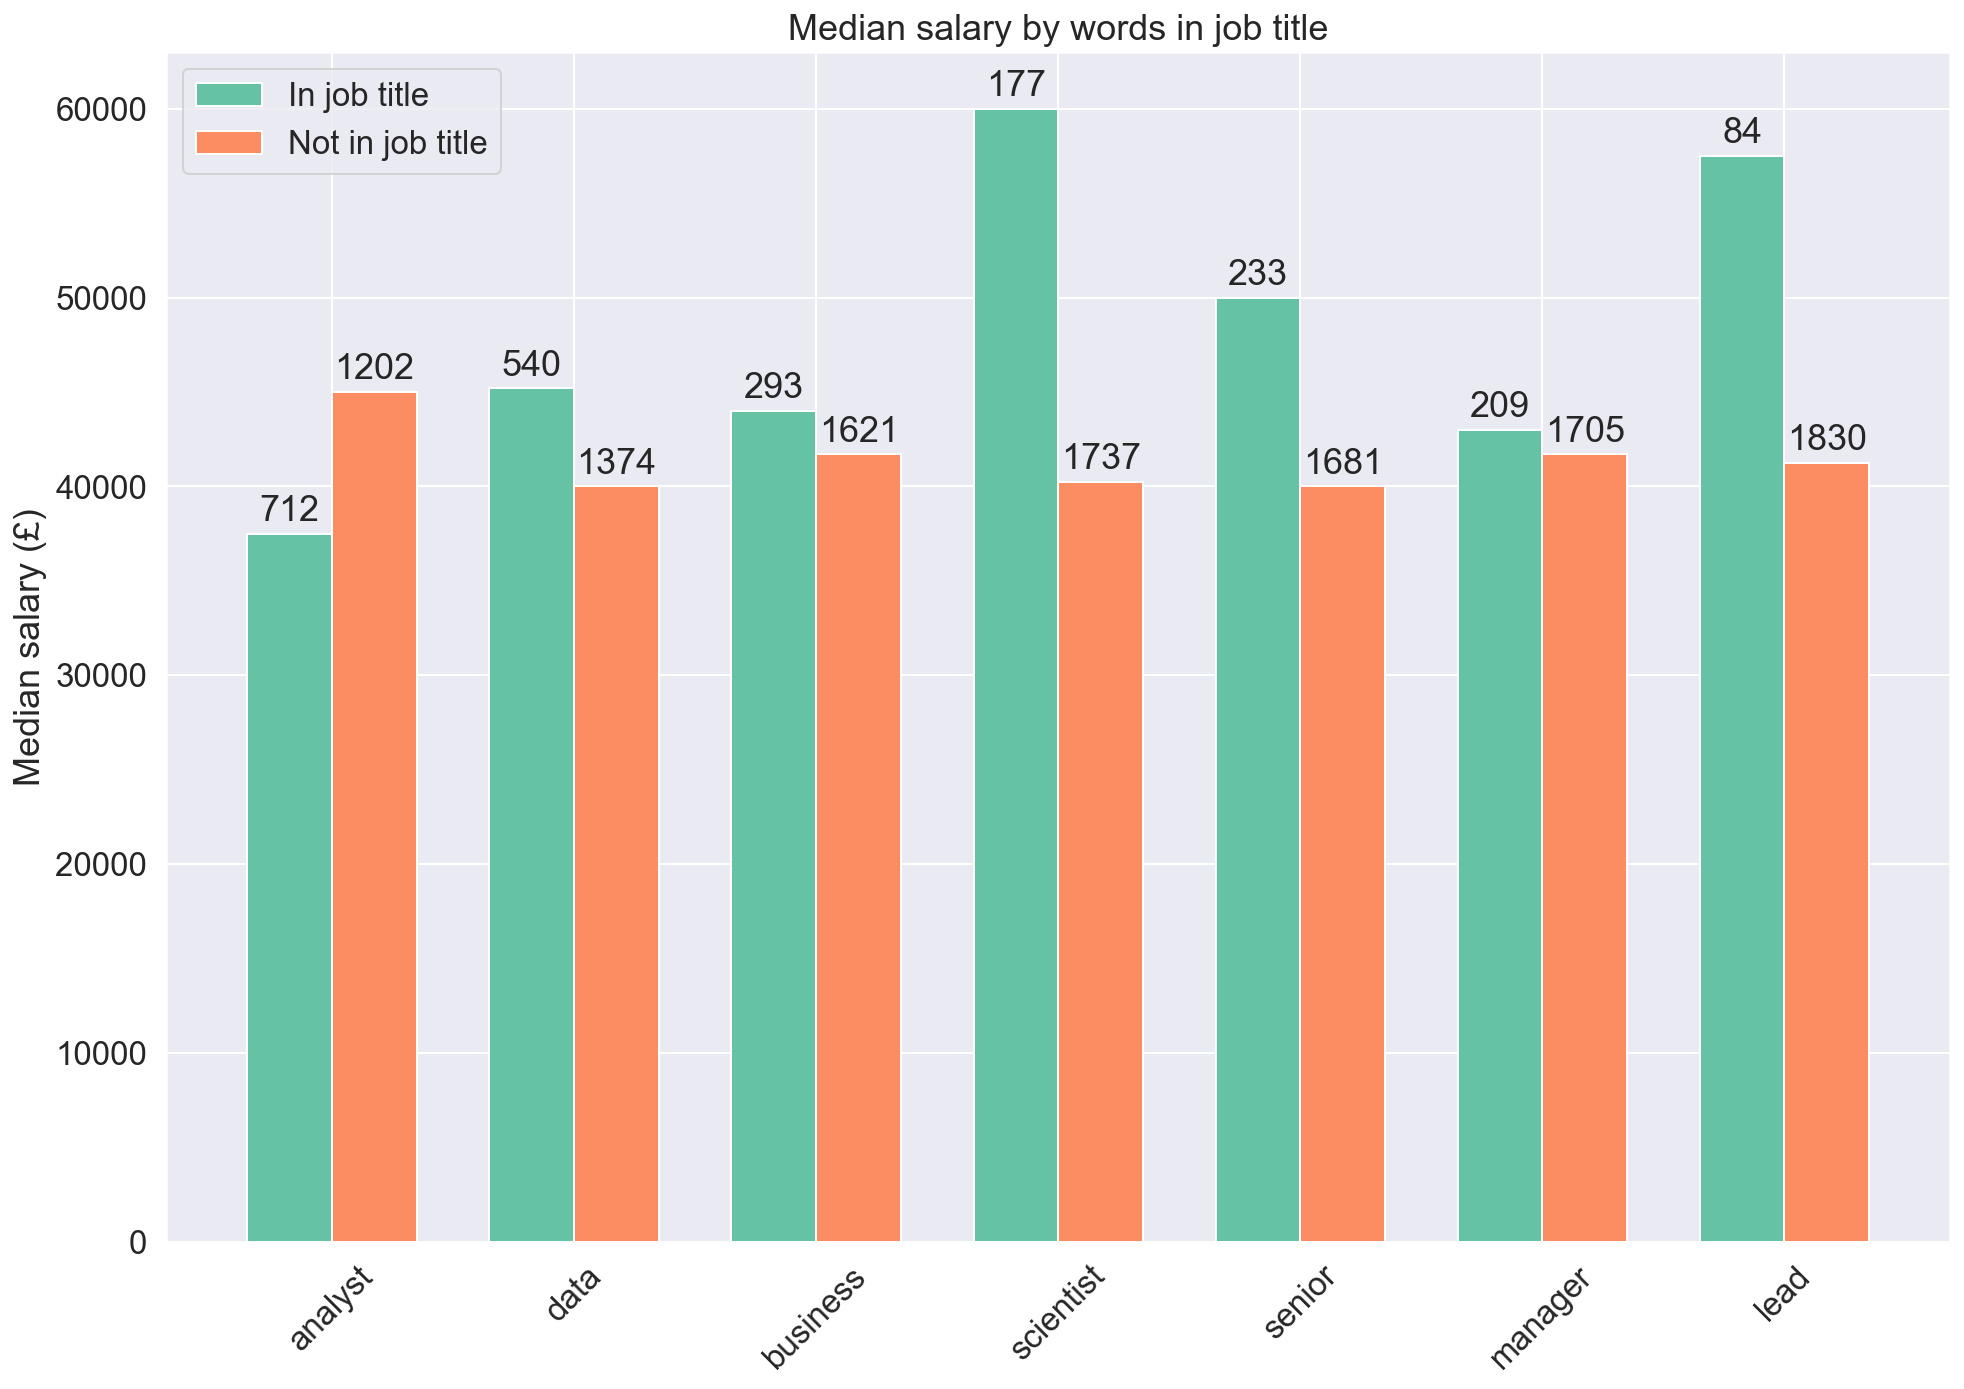

In [15]:
x = np.arange(len(words))  # the label locations
width = 0.35  # the width of the bars

fig3, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, median_in, width, label='In job title')
rects2 = ax.bar(x + width/2, median_not_in, width, label='Not in job title')

ax.set_ylabel('Median salary (£)')
ax.set_title('Median salary by words in job title')
ax.set_xticks(x)
ax.set_xticklabels(words, rotation=45)
ax.set_ylim()
ax.legend()

def autolabel(rects, labels):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{}'.format(labels[i]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1, count_in)
autolabel(rects2, count_not_in)

fig3.tight_layout()
plt.show()

#### Median salary by words in job title
The bar chart above looks at some of the most frequently occurring words in the job title (as identified above) and for each word, the median salary for the jobs which include that word in the title and the median salary for the jobs which do not. The numbers above the bars show the total number of job listings in that category.   

The word 'scientist' for example, shows a median salary of £60,000 for the 177 job listings which have 'scientist' in the title, and approximately £40,000 for the 1,737 job listings without 'scientist' in the title. This implies that having 'scientist' in the job title should be a good predictor of high salaries. Similarly 'senior' and 'lead' point to higher salaries whilst 'analyst' points to lower salaries.

#### Job summary
Use Natural Language Processing on the job summary to see if we can extract words or combinations of words which may be good predictors of salary (e.g. information on the sector).  

There is a lot of overlap between job summary and job title (unsurprisingly!). Try excluding the words from job title to see if job summary contains anything else interesting.

In [16]:
from sklearn.feature_extraction import text 

my_stop_words = text.ENGLISH_STOP_WORDS.union(job_title_words)

In [17]:
tvec = CountVectorizer(stop_words=my_stop_words,
                       ngram_range=(1,1))
tmat = tvec.fit_transform(df.job_summary)

In [18]:
# look at 20 most frequently occurring words
pd.DataFrame(np.array(tmat.sum(axis=0))[0],
             index=tvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:20]

,counts
using,142
provide,110
looking,108
strong,106
develop,104
including,92
ability,90
ensure,79
understanding,77
providing,76


This list of words shows the most frequent words in the job summaries excluding the words from the job titles. I was hoping to see more words about the industry. This does not look very useful. Further investigation is needed to see if we can extract useful information from the job summaries.

#### Company
Use Natural Language Processing on the company name to see if we can extract anything interesting.

In [19]:
cvec = CountVectorizer(stop_words='english',
                       ngram_range=(1,1))
cmat = cvec.fit_transform(df.company)

In [20]:
# look at 20 most frequently occurring words
pd.DataFrame(np.array(cmat.sum(axis=0))[0],
             index=cvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:20]

,counts
recruitment,255
uk,153
group,106
nhs,96
harnham,82
page,70
university,66
consulting,64
government,59
solutions,55


The list shows the most frequently used words in the company column. It helps to identify jobs advertised by recruitment agencies (from words like 'recruitment' but also 'Harnham' which is a recruitment agency) as well as those at a university or for the NHS or the government. This could be useful to help predict salaries. 

#### Company rating
Only approximately half of the listings have a company rating. It could be misleading to impute values for the remaining companies so instead convert company rating to a  categorical variable so that we can test it in our models.

In [21]:
df.company_rating.isnull().sum()/df.shape[0]

0.4780564263322884

In [22]:
# function to categorise the company rating column
def categorise_rating(rating):
    try:
        return str(rating)
    except:
        return 'NA'

In [23]:
df['rating_category'] = df.company_rating.map(categorise_rating)

## Modelling

### Part 1: using location only as the predictor variable
The target variable is the salary. We will treat this as a classification problem to help remove some of the noise of the extreme salaries.   

Create a binary classification problem, with two classes for salary - *high* and *low*. We will split the data on the median, so that we have a balanced dataset, with ~50% classified as high and ~50% classified as low. By definition, the baseline accuracy will be ~50%.

Initially, we will only consider the location as the predictor variable.

In [24]:
# define target variable y as 'high' or 'low' salary, split on the median
median_salary = df.annualised_salary.median()
y = ((df.annualised_salary > median_salary)*1).map({1: 'high', 0: 'low'})
print(f'The median salary is £{median_salary}.')

The median salary is £41914.25.


In [26]:
# do train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df, y, stratify=y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1531, 12), (383, 12), (1531,), (383,))

In [27]:
# create pipeline including dummification of 'region'
# include scaling although not strictly necessary here
one_hot = OneHotEncoder(sparse=False, drop='first')

col_trans_1 = ColumnTransformer([('categories', one_hot, ['region'])], 
                                remainder='drop', 
                                sparse_threshold=0) 

pipe1 = Pipeline(steps=[('col_trans', col_trans_1),
                        ('scaler', StandardScaler(with_mean=False))])

In [28]:
X1_train = pipe1.fit_transform(X_train)
X1_test = pipe1.transform(X_test)
X1_train.shape, X1_test.shape

((1531, 11), (383, 11))

#### Logistic Regression

In [44]:
log_reg_1 = LogisticRegression(max_iter=10000)

params = {'penalty': ['l1', 'l2'],
          'solver': ['saga'],
          'fit_intercept': [True, False],
          'C': np.logspace(-5, 1, 50)}

log_reg_1_gs = GridSearchCV(log_reg_1,
                            params,
                            cv=5,
                            n_jobs=-2,  
                            verbose=3)

log_reg_1_gs.fit(X1_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done 788 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done 1000 out of 1000 | elapsed:    2.4s finished


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-2,
             param_grid={'C': array([1.00000000e-05, 1.32571137e-05, 1.75751062e-05, 2.32995181e-05,
       3.08884360e-05, 4.09491506e-05, 5.42867544e-05, 7.19685673e-05,
       9.54095476e-05, 1.26485522e-04, 1.67683294e-04, 2.22299648e-04,
       2.94705170e-04, 3.90693994e-04, 5.17947468e-04, 6.86648845e-04,
       9.10298178e-04...
       8.28642773e-02, 1.09854114e-01, 1.45634848e-01, 1.93069773e-01,
       2.55954792e-01, 3.39322177e-01, 4.49843267e-01, 5.96362332e-01,
       7.90604321e-01, 1.04811313e+00, 1.38949549e+00, 1.84206997e+00,
       2.44205309e+00, 3.23745754e+00, 4.29193426e+00, 5.68986603e+00,
       7.54312006e+00, 1.00000000e+01]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'], 'solver': ['saga']},
             verbose=3)

In [45]:
print('Best parameters:')
print(log_reg_1_gs.best_params_)
print('Best estimator C:')
print(log_reg_1_gs.best_estimator_.C)
print('Best estimator mean cross-validated training score:')
print(log_reg_1_gs.best_score_)
print('Best estimator score on the full training set:')
print(log_reg_1_gs.score(X1_train, y_train))
print('Best estimator score on the test set:')
print(log_reg_1_gs.score(X1_test, y_test))

Best parameters:
{'C': 4.094915062380427e-05, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga'}
Best estimator C:
4.094915062380427e-05
Best estimator mean cross-validated training score:
0.6322794916012008
Best estimator score on the full training set:
0.6322664924885696
Best estimator score on the test set:
0.6135770234986945


#### Random Forest

In [37]:
random_forest_1 = RandomForestClassifier(n_estimators=300,
                                         min_samples_leaf=1,
                                         n_jobs=-2,
                                         random_state=1)
random_forest_1.fit(X1_train, y_train)

cv_scores = cross_val_score(random_forest_1, X1_train, y_train, cv=5)
print('Mean cross-validated training score:', cv_scores.mean())
print('Score on the full training set:', random_forest_1.score(X1_train, y_train))
print('Score on the test set:', random_forest_1.score(X1_test, y_test))

Mean cross-validated training score: 0.6322794916012008
Score on the full training set: 0.6322664924885696
Score on the test set: 0.6135770234986945


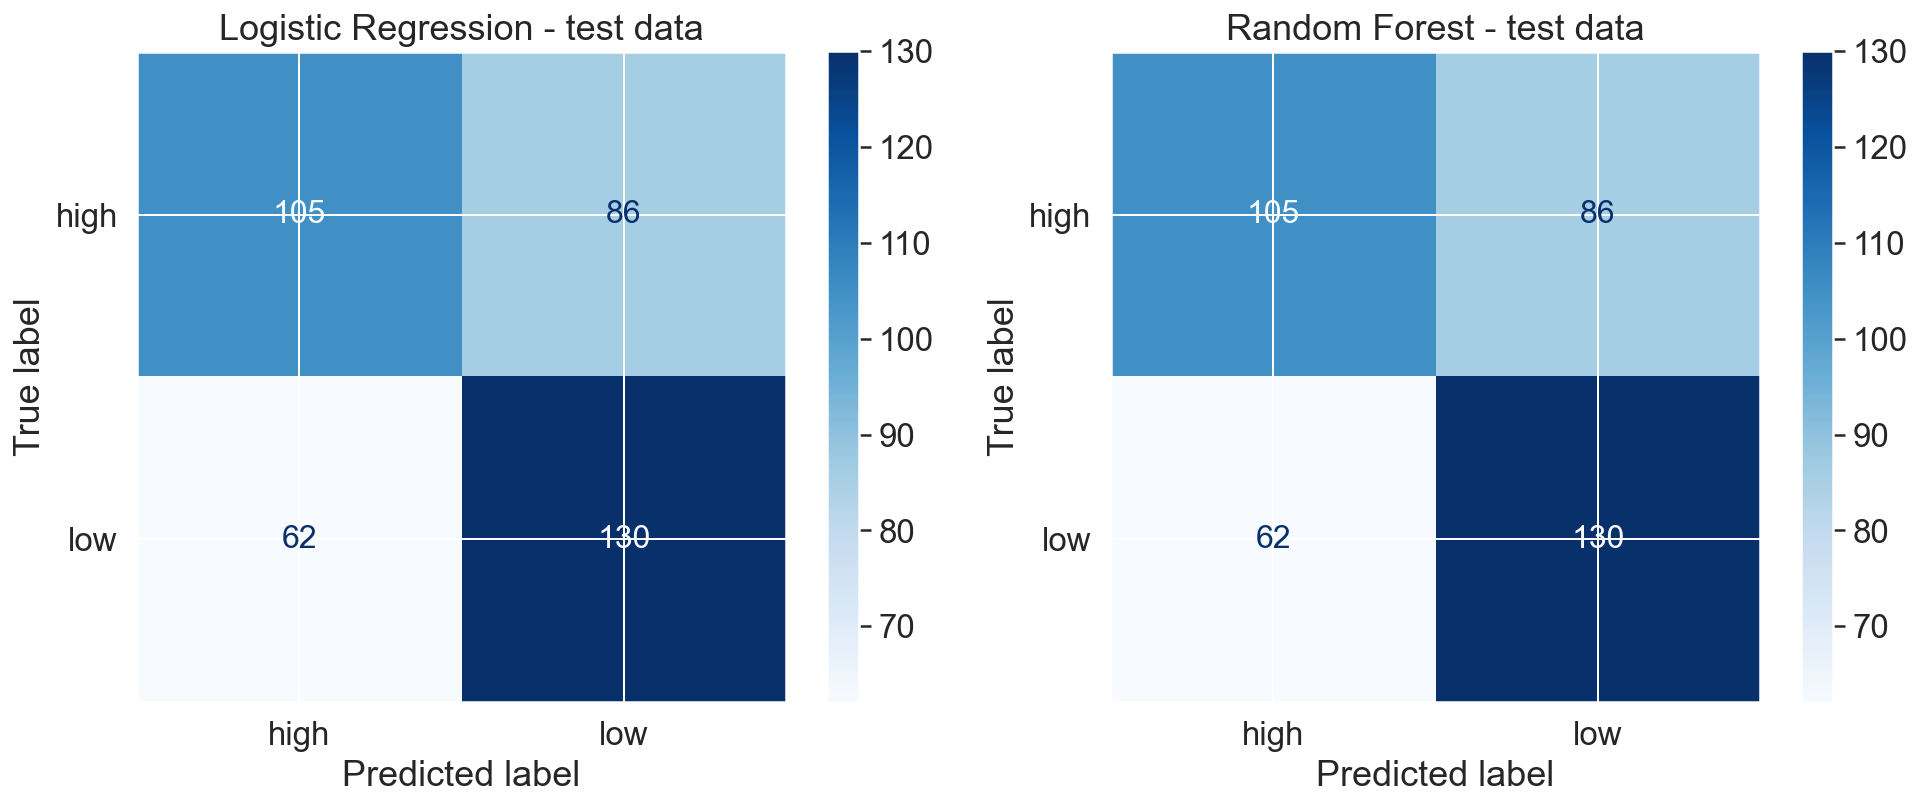

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
plot_confusion_matrix(log_reg_1_gs.best_estimator_, X1_test, y_test, cmap='Blues', ax=ax[0])
plot_confusion_matrix(random_forest_1, X1_test, y_test, cmap='Blues', ax=ax[1])
ax[0].set_title('Logistic Regression - test data')
ax[1].set_title('Random Forest - test data')
for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)
plt.show()

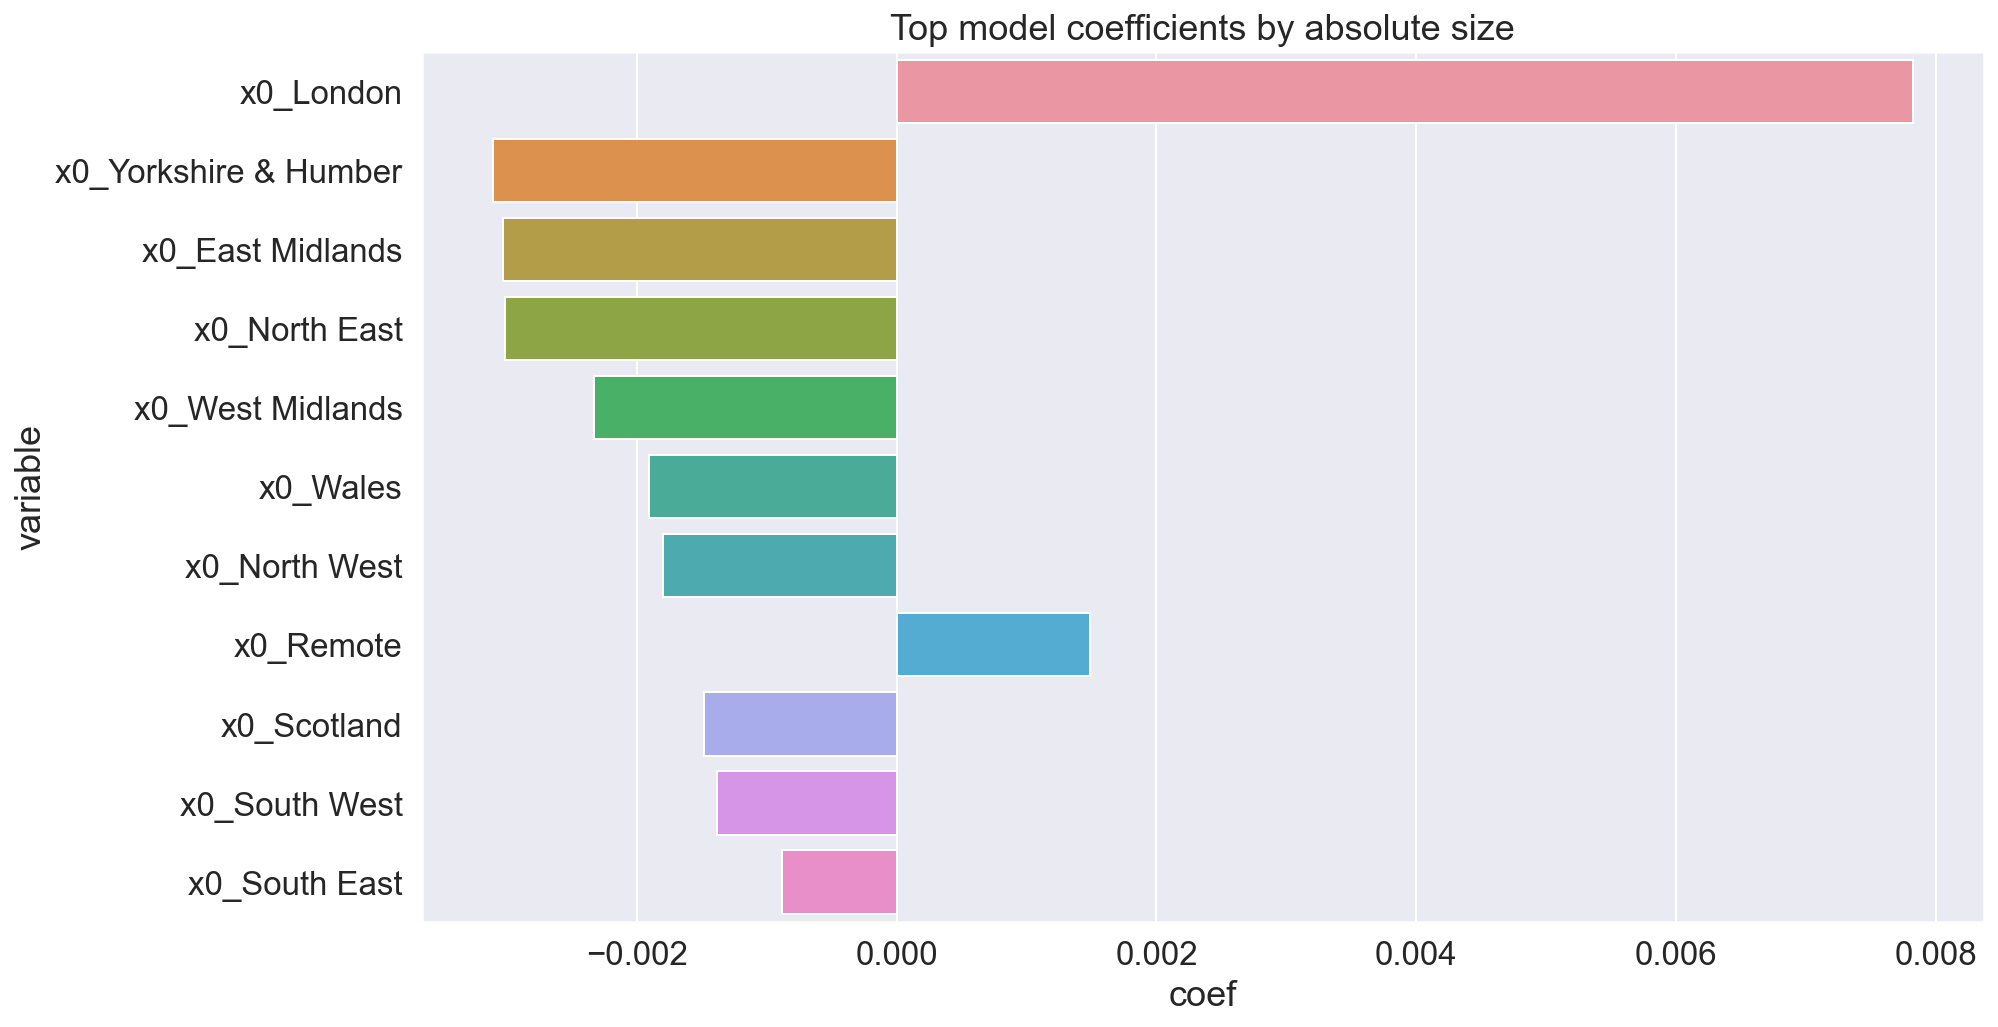

In [60]:
# plot model coefficients for logistic regression
model = log_reg_1_gs.best_estimator_
df_coef = pd.DataFrame({'variable': col_trans_1.named_transformers_['categories'].get_feature_names(), 
                        'coef': -model.coef_[0], 
                        'coef_abs': np.abs(model.coef_[0])})

fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_coef.sort_values('coef_abs', ascending=False).head(20), x='coef', y='variable')
plt.title('Top model coefficients by absolute size')
plt.show()

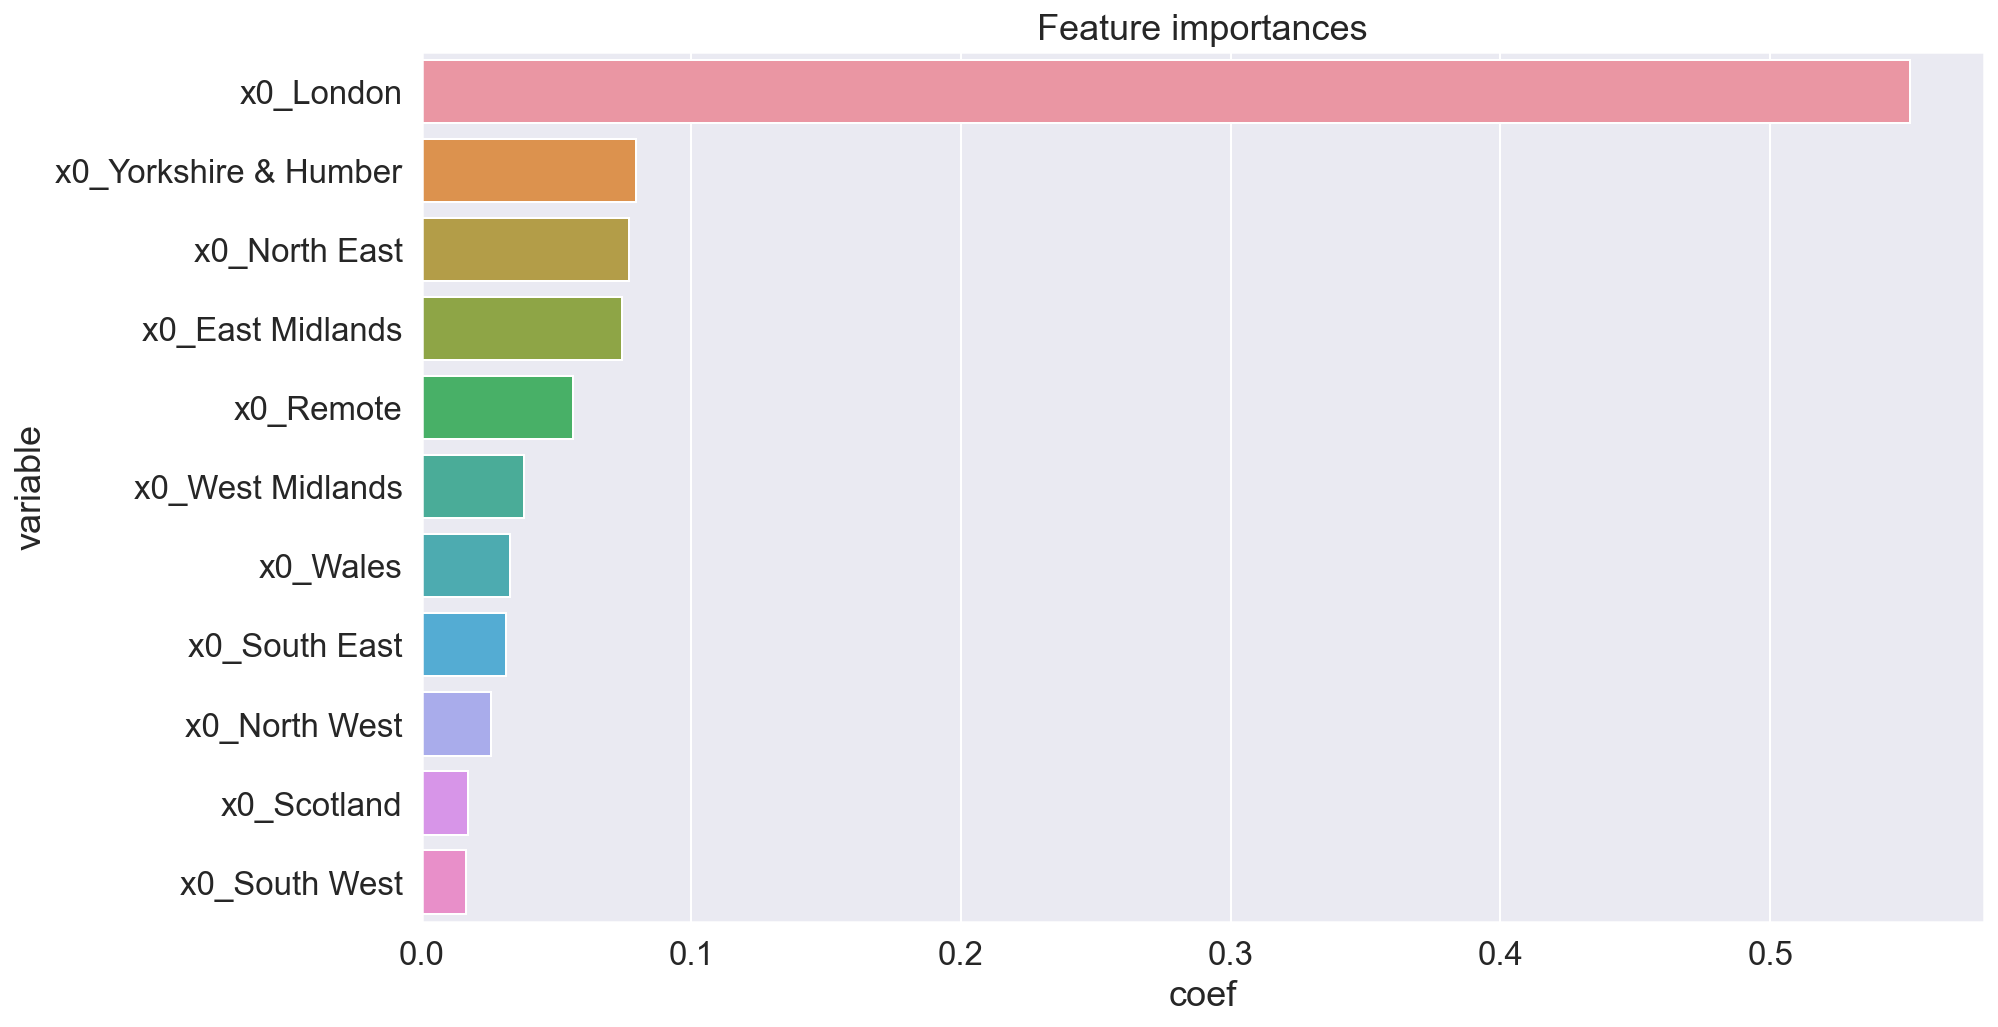

In [40]:
# plot feature importances for random forest
model = random_forest_1
df_coef = pd.DataFrame({'variable': col_trans_1.named_transformers_['categories'].get_feature_names(), 
                        'coef': model.feature_importances_})

fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_coef.sort_values('coef', ascending=False).head(20), x='coef', y='variable')
plt.title('Feature importances')
plt.show()

#### Conclusion to part 1
I ran a logistic regression model and a random forest model using just location as a predictor. Both models perform very similarly and give a mean cross-validated accuracy score of 0.6323, well above baseline but not particularly high. Location is a good predictor but we will need to add other features to improve the score. 

The confusion matrices on the test data are shown above - both models are better at predicting low salaries, predicting 130 out of 192 correctly (and 105 out of 191 for high salaries).

The two bar charts show the feature importances, which largely agree between the two models. London is the most important in both cases. The coefficients for the logistic regression model indicate the direction of the impact of the features (positive or negative) as well - London and Remote both point towards a high salary and the remaining regions point towards a low salary.

Next steps: add in more features to try and improve the model scores.

### Part 2: adding in more features
Add in more features to try and improve the model scores. Add and check scores with the following:
- add salary type (how the salary is quoted e.g. annual, daily) as a categorical variable
- do some NLP on the job title (as above) and add as a feature
- do some NLP on the company name (as above) and add as a feature
- add company rating as a categorical variable
- do some NLP on the job summary (as above) and add as a feature

In [46]:
# create pipepline with additional features
one_hot_1 = OneHotEncoder(sparse=False, drop='first')
one_hot_2 = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')

tvec_title = TfidfVectorizer(stop_words='english',
                             ngram_range=(1,1),
                             max_features=None,
                             min_df=1)

cvec_company = CountVectorizer(stop_words='english',
                               ngram_range=(1,1),
                               max_features=None,
                               min_df=1)

col_trans_2 = ColumnTransformer([('job_title', tvec_title, 'job_title'),
                                 ('company', cvec_company, 'company'),
                                 ('categories', one_hot_1, ['region', 'salary_type']),
                                 ('rating', one_hot_2, ['rating_category'])],  
                                remainder='drop', 
                                sparse_threshold=0.6) 

pipe2 = Pipeline(steps=[('col_trans', col_trans_2),
                        ('scaler', StandardScaler(with_mean=False))])

In [47]:
X2_train = pipe2.fit_transform(X_train)
X2_test = pipe2.transform(X_test)
X2_train

<1531x2011 sparse matrix of type '<class 'numpy.float64'>'
	with 12264 stored elements in Compressed Sparse Row format>

#### Logistic Regression

In [48]:
log_reg_2 = LogisticRegression(max_iter=10000)

params = {'penalty': ['l2'],
          'solver': ['saga'],
          'fit_intercept': [True, False],
          'C': np.logspace(-5, 1, 50)}

log_reg_2_gs = GridSearchCV(log_reg_2,
                            params,
                            cv=5,
                            n_jobs=-2,  
                            verbose=3)

log_reg_2_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-2)]: Done 478 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:   14.0s finished


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-2,
             param_grid={'C': array([1.00000000e-05, 1.32571137e-05, 1.75751062e-05, 2.32995181e-05,
       3.08884360e-05, 4.09491506e-05, 5.42867544e-05, 7.19685673e-05,
       9.54095476e-05, 1.26485522e-04, 1.67683294e-04, 2.22299648e-04,
       2.94705170e-04, 3.90693994e-04, 5.17947468e-04, 6.86648845e-04,
       9.10298178e-04...
       2.68269580e-02, 3.55648031e-02, 4.71486636e-02, 6.25055193e-02,
       8.28642773e-02, 1.09854114e-01, 1.45634848e-01, 1.93069773e-01,
       2.55954792e-01, 3.39322177e-01, 4.49843267e-01, 5.96362332e-01,
       7.90604321e-01, 1.04811313e+00, 1.38949549e+00, 1.84206997e+00,
       2.44205309e+00, 3.23745754e+00, 4.29193426e+00, 5.68986603e+00,
       7.54312006e+00, 1.00000000e+01]),
                         'fit_intercept': [True, False], 'penalty': ['l2'],
                         'solver': ['saga']},
             verbose=3)

In [49]:
print('Best parameters:')
print(log_reg_2_gs.best_params_)
print('Best estimator C:')
print(log_reg_2_gs.best_estimator_.C)
print('Best estimator mean cross-validated training score:')
print(log_reg_2_gs.best_score_)
print('Best estimator score on the full training set:')
print(log_reg_2_gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(log_reg_2_gs.score(X2_test, y_test))

Best parameters:
{'C': 0.0021209508879201904, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga'}
Best estimator C:
0.0021209508879201904
Best estimator mean cross-validated training score:
0.7824955823806178
Best estimator score on the full training set:
0.9666884389288047
Best estimator score on the test set:
0.7597911227154047


#### Random Forest

In [51]:
random_forest_2 = RandomForestClassifier(n_estimators=300,
                                         max_depth=None,
                                         min_samples_leaf=1,
                                         n_jobs=-2,
                                         random_state=1)
random_forest_2.fit(X2_train, y_train)

cv_scores = cross_val_score(random_forest_2, X2_train, y_train, cv=5)
print('Mean cross-validated training score:', cv_scores.mean())
print('Score on the full training set:', random_forest_2.score(X2_train, y_train))
print('Score on the test set:', random_forest_2.score(X2_test, y_test))

Mean cross-validated training score: 0.793598177598944
Score on the full training set: 1.0
Score on the test set: 0.7859007832898173


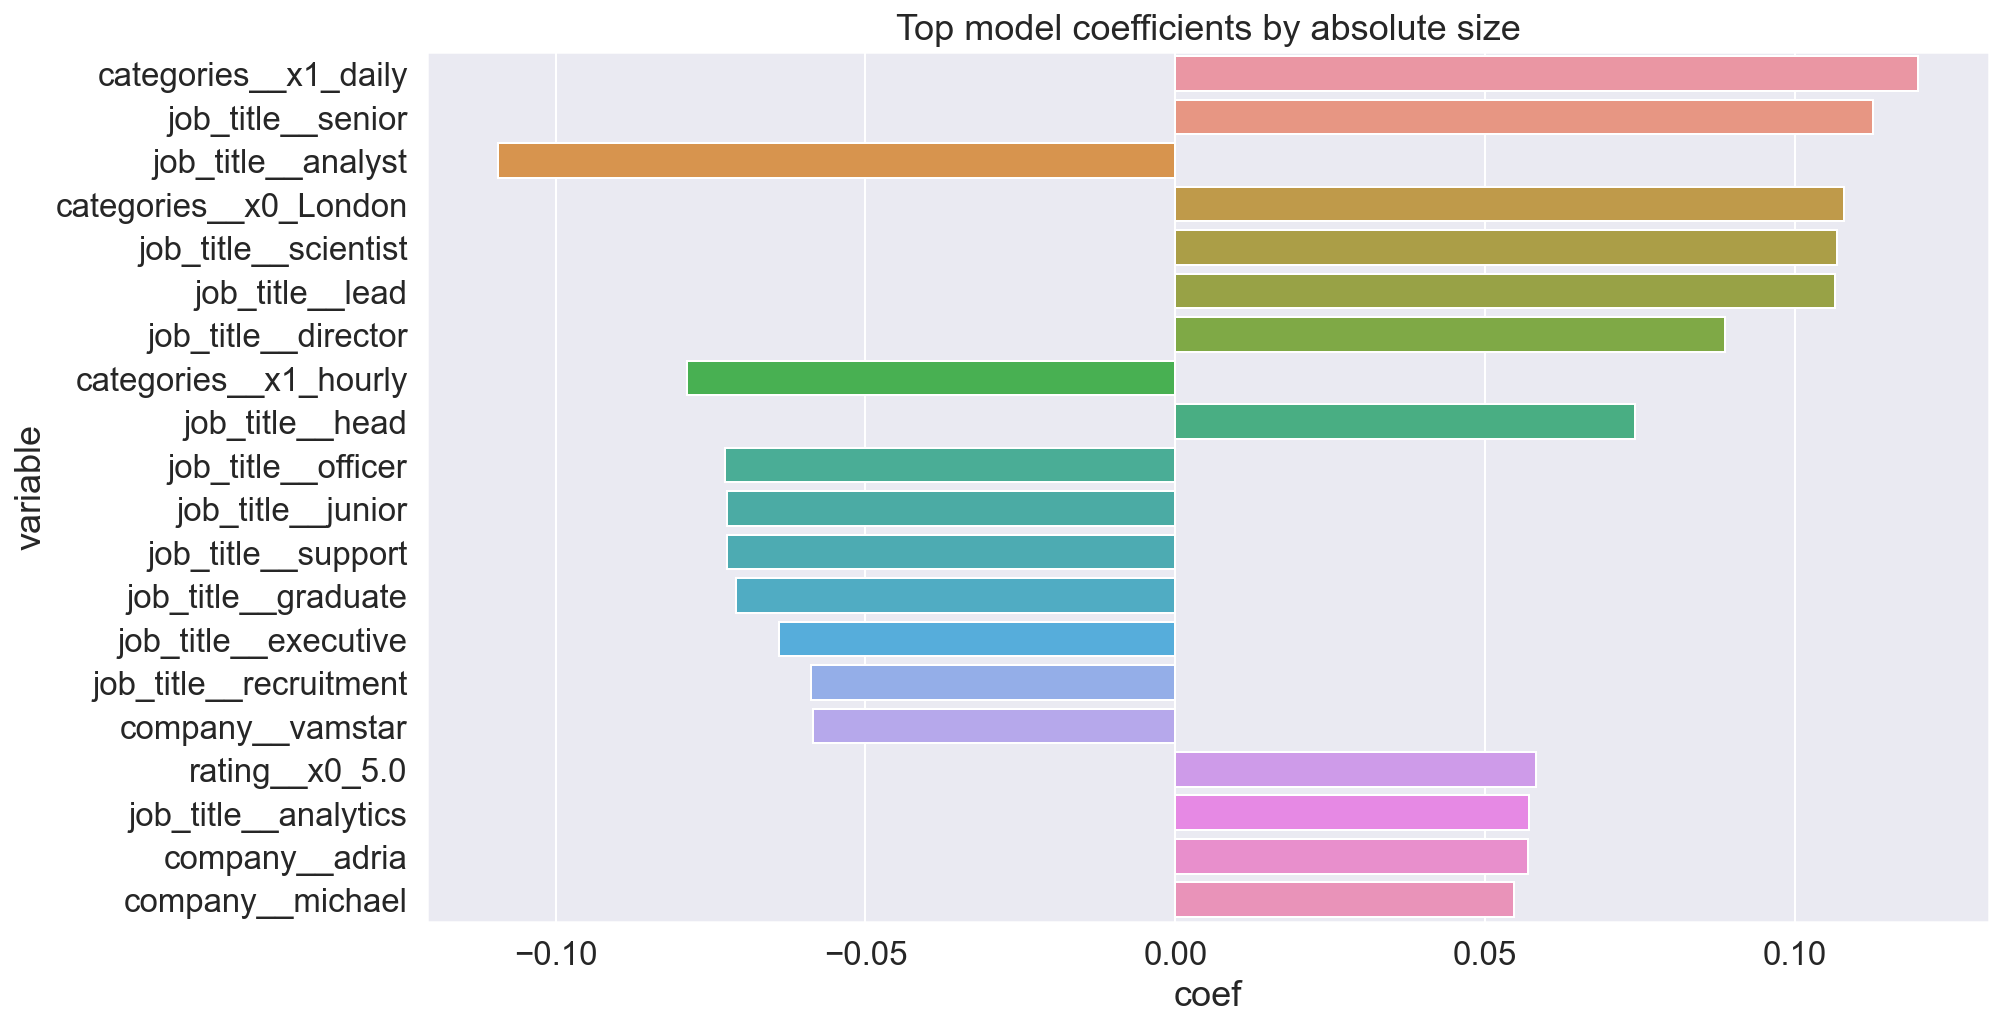

In [61]:
# plot model coefficients for logistic regression
model = log_reg_2_gs.best_estimator_
df_coef = pd.DataFrame({'variable': col_trans_2.get_feature_names(), 
                        'coef': -model.coef_[0], 
                        'coef_abs': np.abs(model.coef_[0])})

fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_coef.sort_values('coef_abs', ascending=False).head(20), x='coef', y='variable')
plt.title('Top model coefficients by absolute size')
plt.show()

#### Comment on additional features
I tested adding in the additional features mentioned above:
- **Job title**    
This had the largest effect and increased the accuracy score by approximately 0.11. I tested using CountVectorizer and TfidfVectorizer and including unigrams and bigrams or just unigrams - the best combination was TfidfVectorizer and including only unigrams.   
The bar chart above shows the model coefficients from the logistic regression model. Many words from the job title feature in the largest 20 coefficients e.g. 'senior', 'scientist', 'lead', 'director', 'head' which point to high salaries and 'analyst', 'officer', 'junior', 'support', 'graduate' which point to low salaries.    
- **Salary type**    
Adding in salary type (how the salary is quoted) made a small improvement to the accuracy score. The bar chart above shows the largest model coefficient to be salaries quoted daily (pointing to high salaries). Salaries quoted hourly also feature as one of the largest model coefficients (pointing to low salaries).
- **Company**     
Adding in the company after some NLP also improved the score slightly. CountVectorizer gave a larger improvement than TfidfVectorizer.
- **Company rating**    
Adding in the company rating also helped to improve the score. A company rating of 5 (out of 5) appears in the largest 20 model coefficients above (pointing to high salaries).
- **Job summary**   
I tested adding in features from the job summary after some NLP. There is a lot of overlap with the words in the job title so I also tested removing the overlapping words. Neither method helped to improve the score so I left it out for now. Further investigation is needed to see if some useful information could be extracted from the job summary which we have not captured elsewhere.

### Part 3: select and optimise the model
I have tried two different classifiers so far, logistic regression and random forest. Let's tune these classifiers and try some others to achieve the best accuracy score. Add scores and best model parameters to a dataframe for easy comparison.

In [150]:
# create empty dictionary to store different model results in for easy comparison
scores_dict = {'model_name': [],
               'mean_cv_score': [],
               'training_score': [],
               'test_score': [],
               'precision_high': [],
               'recall_high': [],
               'precision_low': [],
               'recall_low': [],
               'roc_auc_score': [],
               'model_params': []}

In [151]:
# function to add gridsearch model results to dictionary
def add_gs_model(model_name, model):
    scores_dict['model_name'].append(model_name)
    scores_dict['mean_cv_score'].append(model.best_score_)
    scores_dict['training_score'].append(model.score(X2_train, y_train))
    scores_dict['test_score'].append(model.score(X2_test, y_test))
    scores_dict['precision_high'].append(precision_score(y_test, model.predict(X2_test), pos_label='high'))
    scores_dict['recall_high'].append(recall_score(y_test, model.predict(X2_test), pos_label='high'))                                       
    scores_dict['precision_low'].append(precision_score(y_test, model.predict(X2_test), pos_label='low'))
    scores_dict['recall_low'].append(recall_score(y_test, model.predict(X2_test), pos_label='low'))                               
    scores_dict['roc_auc_score'].append(roc_auc_score(y_test, model.predict_proba(X2_test)[:, 1]))
    scores_dict['model_params'].append(model.best_params_)

#### Logistic Regression

In [64]:
log_reg_3 = LogisticRegression(max_iter=10000)

params = {'penalty': ['l2', 'l1'],
          'solver': ['saga'],
          'fit_intercept': [True, False],
          'C': np.logspace(-5, 1, 20)}

log_reg_3_gs = GridSearchCV(log_reg_3,
                            params,
                            cv=5,
                            n_jobs=-2,  
                            verbose=3)

log_reg_3_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-2)]: Done 358 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-2)]: Done 400 out of 400 | elapsed:  3.3min finished


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-2,
             param_grid={'C': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]),
                         'fit_intercept': [True, False],
                         'penalty': ['l2', 'l1'], 'solver': ['saga']},
             verbose=3)

In [65]:
print('Best parameters:')
print(log_reg_3_gs.best_params_)
print('Best estimator C:')
print(log_reg_3_gs.best_estimator_.C)
print('Best estimator mean cross-validated training score:')
print(log_reg_3_gs.best_score_)
print('Best estimator score on the full training set:')
print(log_reg_3_gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(log_reg_3_gs.score(X2_test, y_test))

Best parameters:
{'C': 0.1274274985703132, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Best estimator C:
0.1274274985703132
Best estimator mean cross-validated training score:
0.7883736773754018
Best estimator score on the full training set:
0.9751796211626388
Best estimator score on the test set:
0.7989556135770235


In [152]:
add_gs_model('Logistic regression', log_reg_3_gs)

#### KNN

In [67]:
knn = KNeighborsClassifier()

params = {'n_neighbors': range(1, 16, 1),
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']}

knn_gs = GridSearchCV(knn,
                      params,
                      cv=5,
                      n_jobs=-2,  
                      verbose=3)

knn_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 268 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:    1.5s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-2,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 16),
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [68]:
print('Best parameters:')
print(knn_gs.best_params_)
print('Best estimator mean cross-validated training score:')
print(knn_gs.best_score_)
print('Best estimator score on the full training set:')
print(knn_gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(knn_gs.score(X2_test, y_test))

Best parameters:
{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best estimator mean cross-validated training score:
0.6936726916608121
Best estimator score on the full training set:
1.0
Best estimator score on the test set:
0.7023498694516971


In [153]:
add_gs_model('KNN', knn_gs)

#### Bagging classifier with KNN base estimator

In [125]:
bag_knn = BaggingClassifier(base_estimator=knn,
                            n_estimators=300,
                            random_state=1)

params = {'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'base_estimator__n_neighbors': [1, 2, 3]}

bag_knn_gs = GridSearchCV(bag_knn,
                          params,
                          n_jobs=-2, 
                          cv=5, 
                          verbose=3)

bag_knn_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    3.8s
/Users/julia/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-2)]: Done 498 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-2)]: Done 630 out of 630 | elapsed:  2.8min finished


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(),
                                         n_estimators=300, random_state=1),
             n_jobs=-2,
             param_grid={'base_estimator__n_neighbors': [1, 2, 3],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0],
                         'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             verbose=3)

In [126]:
print('Best parameters:')
print(bag_knn_gs.best_params_)
print('Best estimator mean cross-validated training score:')
print(bag_knn_gs.best_score_)
print('Best estimator score on the full training set:')
print(bag_knn_gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(bag_knn_gs.score(X2_test, y_test))

Best parameters:
{'base_estimator__n_neighbors': 3, 'max_features': 0.2, 'max_samples': 0.9}
Best estimator mean cross-validated training score:
0.7831640799642333
Best estimator score on the full training set:
0.9666884389288047
Best estimator score on the test set:
0.7650130548302873


In [154]:
add_gs_model('Bagging with KNN', bag_knn_gs)

#### Decision tree

In [73]:
decision_tree = DecisionTreeClassifier(random_state=1)

params = {'max_depth': [None]+list(range(1, 101, 5)),
          'max_features': range(int(0.5*(X2_train.shape[1])), X2_train.shape[1]+1, 50),
          'min_samples_split': [2, 3, 4, 5, 10],
          'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01]}

decision_tree_gs = GridSearchCV(decision_tree,
                                params,
                                n_jobs=-2, 
                                cv=5, 
                                verbose=3)

decision_tree_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 11025 candidates, totalling 55125 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-2)]: Done 674 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done 5450 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-2)]: Done 7860 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-2)]: Done 9588 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-2)]: Done 11700 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-2)]: Done 21462 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 32982 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 46038 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 55125 out of 55125 | elapsed:  3.1min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-2,
             param_grid={'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01],
                         'max_depth': [None, 1, 6, 11, 16, 21, 26, 31, 36, 41,
                                       46, 51, 56, 61, 66, 71, 76, 81, 86, 91,
                                       96],
                         'max_features': range(1005, 2012, 50),
                         'min_samples_split': [2, 3, 4, 5, 10]},
             verbose=3)

In [91]:
print('Best parameters:')
print(decision_tree_gs.best_params_)
print('Best estimator mean cross-validated training score:')
print(decision_tree_gs.best_score_)
print('Best estimator score on the full training set:')
print(decision_tree_gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(decision_tree_gs.score(X2_test, y_test))

Best parameters:
{'ccp_alpha': 0, 'max_depth': None, 'max_features': 1605, 'min_samples_split': 3}
Best estimator mean cross-validated training score:
0.7668305976027762
Best estimator score on the full training set:
0.9967341606792945
Best estimator score on the test set:
0.7180156657963447


In [155]:
add_gs_model('Decision tree', decision_tree_gs)

#### Bagging classifier with decision tree base estimator

In [77]:
bag_dt = BaggingClassifier(base_estimator=decision_tree,
                           n_estimators=300,
                           n_jobs=-2)

params = {'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'base_estimator__max_depth': [None]}

bag_dt_gs = GridSearchCV(bag_dt,
                         params,
                         n_jobs=-2, 
                         cv=5, 
                         verbose=3)

bag_dt_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 180 out of 180 | elapsed:  2.0min finished


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1),
                                         n_estimators=300, n_jobs=-2),
             n_jobs=-2,
             param_grid={'base_estimator__max_depth': [None],
                         'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                         'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             verbose=3)

In [78]:
print('Best parameters:')
print(bag_dt_gs.best_params_)
print('Best estimator mean cross-validated training score:')
print(bag_dt_gs.best_score_)
print('Best estimator score on the full training set:')
print(bag_dt_gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(bag_dt_gs.score(X2_test, y_test))

Best parameters:
{'base_estimator__max_depth': None, 'max_features': 0.6, 'max_samples': 1.0}
Best estimator mean cross-validated training score:
0.7968704094015455
Best estimator score on the full training set:
1.0
Best estimator score on the test set:
0.7754569190600522


In [156]:
add_gs_model('Bagging with decision tree', bag_dt_gs)

#### Random Forest

In [146]:
random_forest_3 = RandomForestClassifier(random_state=41)

params = {'n_estimators': [200, 250, 300, 350, 400],
          'max_depth': [None],
          'min_samples_leaf': [1, 2, 3], 
          'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01]}

random_forest_gs = GridSearchCV(random_forest_3,
                                params,
                                n_jobs=-2, 
                                cv=5,
                                verbose=3)

random_forest_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-2)]: Done 375 out of 375 | elapsed:  1.3min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=41), n_jobs=-2,
             param_grid={'ccp_alpha': [0, 0.0001, 0.001, 0.005, 0.01],
                         'max_depth': [None], 'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [200, 250, 300, 350, 400]},
             verbose=3)

In [147]:
print('Best parameters:')
print(random_forest_gs.best_params_)
print('Best estimator mean cross-validated training score:')
print(random_forest_gs.best_score_)
print('Best estimator score on the full training set:')
print(random_forest_gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(random_forest_gs.score(X2_test, y_test))

Best parameters:
{'ccp_alpha': 0.0001, 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400}
Best estimator mean cross-validated training score:
0.7903365906623236
Best estimator score on the full training set:
1.0
Best estimator score on the test set:
0.793733681462141


In [157]:
add_gs_model('Random Forest', random_forest_gs)

#### Ada Boost

In [96]:
base_estimator = DecisionTreeClassifier()

ada_boost = AdaBoostClassifier(base_estimator=base_estimator,
                               random_state=1)

params = {'n_estimators': [200, 250, 300, 350, 400],
          'learning_rate': [0.7, 0.8, 0.9, 1.0],
          'base_estimator__max_features': [0.3, 0.4, 0.5],
          'base_estimator__max_depth': [4, 5, 6]}

ada_boost_gs = GridSearchCV(ada_boost,
                            params,
                            n_jobs=-2, 
                            cv=5, 
                            verbose=3)

ada_boost_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done 114 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-2)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 498 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-2)]: Done 900 out of 900 | elapsed:  4.9min finished


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                          random_state=1),
             n_jobs=-2,
             param_grid={'base_estimator__max_depth': [4, 5, 6],
                         'base_estimator__max_features': [0.3, 0.4, 0.5],
                         'learning_rate': [0.7, 0.8, 0.9, 1.0],
                         'n_estimators': [200, 250, 300, 350, 400]},
             verbose=3)

In [97]:
print('Best parameters:')
print(ada_boost_gs.best_params_)
print('Best estimator mean cross-validated training score:')
print(ada_boost_gs.best_score_)
print('Best estimator score on the full training set:')
print(ada_boost_gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(ada_boost_gs.score(X2_test, y_test))

Best parameters:
{'base_estimator__max_depth': 6, 'base_estimator__max_features': 0.4, 'learning_rate': 1.0, 'n_estimators': 350}
Best estimator mean cross-validated training score:
0.8020927806518916
Best estimator score on the full training set:
1.0
Best estimator score on the test set:
0.7728459530026109


In [158]:
add_gs_model('Ada Boost', ada_boost_gs)

#### Gradient boosting

In [99]:
gradient_boosting = GradientBoostingClassifier(criterion='friedman_mse',
                                               loss='deviance',
                                               validation_fraction=0.1,
                                               n_iter_no_change=20,
                                               random_state=1)

params = {'n_estimators': [2000, 3000],
          'max_depth': [3, 4, 5, 6],
          'learning_rate': [0.001, 0.01, 0,1]}

gradient_boosting_gs = GridSearchCV(gradient_boosting,
                                    params,
                                    n_jobs=-2, 
                                    cv=5, 
                                    verbose=3)

gradient_boosting_gs.fit(X2_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-2)]: Done 121 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done 160 out of 160 | elapsed:  1.9min finished


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_iter_no_change=20,
                                                  random_state=1),
             n_jobs=-2,
             param_grid={'learning_rate': [0.001, 0.01, 0, 1],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [2000, 3000]},
             verbose=3)

In [100]:
print('Best parameters:')
print(gradient_boosting_gs.best_params_)
print('Best estimator mean cross-validated training score:')
print(gradient_boosting_gs.best_score_)
print('Best estimator score on the full training set:')
print(gradient_boosting_gs.score(X2_train, y_train))
print('Best estimator score on the test set:')
print(gradient_boosting_gs.score(X2_test, y_test))

Best parameters:
{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 2000}
Best estimator mean cross-validated training score:
0.798831193715271
Best estimator score on the full training set:
0.969301110385369
Best estimator score on the test set:
0.7676240208877284


In [159]:
add_gs_model('Gradient boosting', gradient_boosting_gs)

#### Results of the different classifiers
I fine-tuned 8 different classifiers using GridSearch and the results are summarised in the dataframe below.

In [160]:
scores_df = pd.DataFrame(scores_dict)
scores_df

,model_name,mean_cv_score,training_score,test_score,precision_high,recall_high,precision_low,recall_low,roc_auc_score,model_params
0,Logistic regression,0.788374,0.975180,0.798956,0.813187,0.774869,0.786070,0.822917,0.850172,"{'C': 0.1274274985703132, 'fit_intercept': Tru..."
1,KNN,0.693673,1.000000,0.702350,0.674208,0.780105,0.740741,0.625000,0.702552,"{'metric': 'manhattan', 'n_neighbors': 1, 'wei..."
2,Bagging with KNN,0.783164,0.966688,0.765013,0.782123,0.732984,0.750000,0.796875,0.861052,"{'base_estimator__n_neighbors': 3, 'max_featur..."
3,Decision tree,0.766831,0.996734,0.718016,0.719577,0.712042,0.716495,0.723958,0.717277,"{'ccp_alpha': 0, 'max_depth': None, 'max_featu..."
4,Bagging with decision tree,0.796870,1.000000,0.775457,0.777778,0.769634,0.773196,0.781250,0.874468,"{'base_estimator__max_depth': None, 'max_featu..."
5,Random Forest,0.790337,1.000000,0.793734,0.814607,0.759162,0.775610,0.828125,0.883890,"{'ccp_alpha': 0.0001, 'max_depth': None, 'min_..."
6,Ada Boost,0.802093,1.000000,0.772846,0.776596,0.764398,0.769231,0.781250,0.864174,"{'base_estimator__max_depth': 6, 'base_estimat..."
7,Gradient boosting,0.798831,0.969301,0.767624,0.807229,0.701571,0.737327,0.833333,0.867365,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est..."


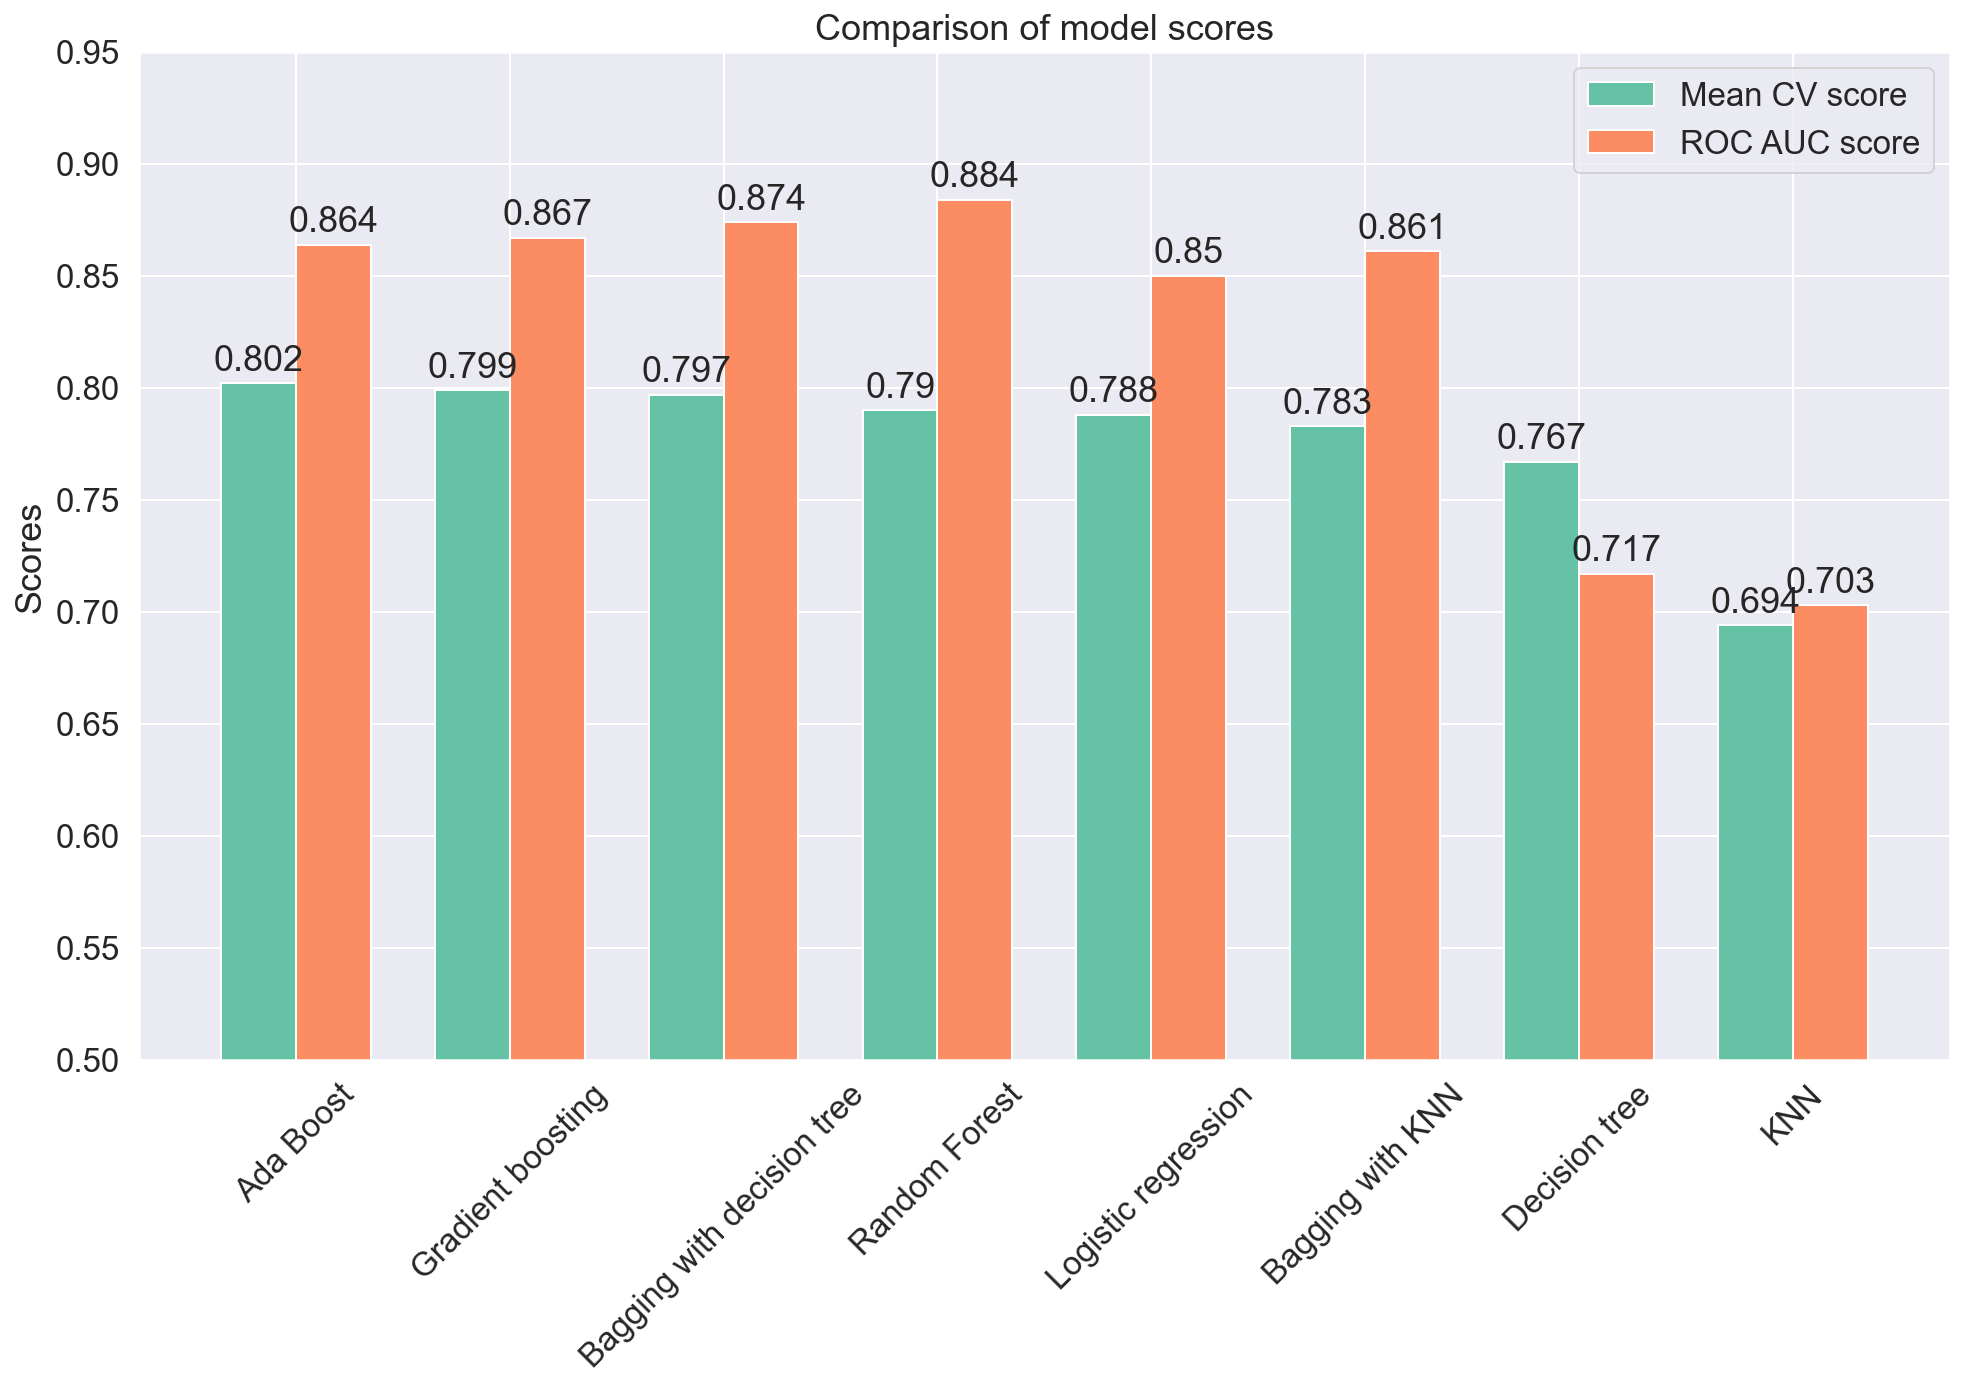

In [161]:
plot_df = scores_df.sort_values(by='mean_cv_score', ascending=False)
labels = plot_df.model_name
mean_cv_scores = round(plot_df.mean_cv_score, 3)
roc_auc_scores = round(plot_df.roc_auc_score, 3)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 10))
rects1 = ax.bar(x - width/2, mean_cv_scores, width, label='Mean CV score')
rects2 = ax.bar(x + width/2, roc_auc_scores, width, label='ROC AUC score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Comparison of model scores')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_ylim(0.5, 0.95)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

#### Comparison of models
The bar chart above shows the mean cross-validated scores and the ROC AUC scores for the 8 different models, ordered by the mean cross-validated scores.   

The KNN and decision tree models are the worst performing, but these classifiers improve with the use of ensemble techniques i.e. bagging or boosting.   

The remaining models have very similar mean cross-validated accuracy scores. The bar chart also shows the ROC AUC scores (the area under the ROC curve) which although directly related to the accuracy scores, is often preferred over the accuracy because it is automatically adjusted to the baseline and gives a robust picture of how the classifier performs at different threshold choices.

Let's look in more detail at the Ada Boost model which has the highest mean cross-validated accuracy score and the Random Forest model which has the highest ROC AUC score.

### Confusion matrices

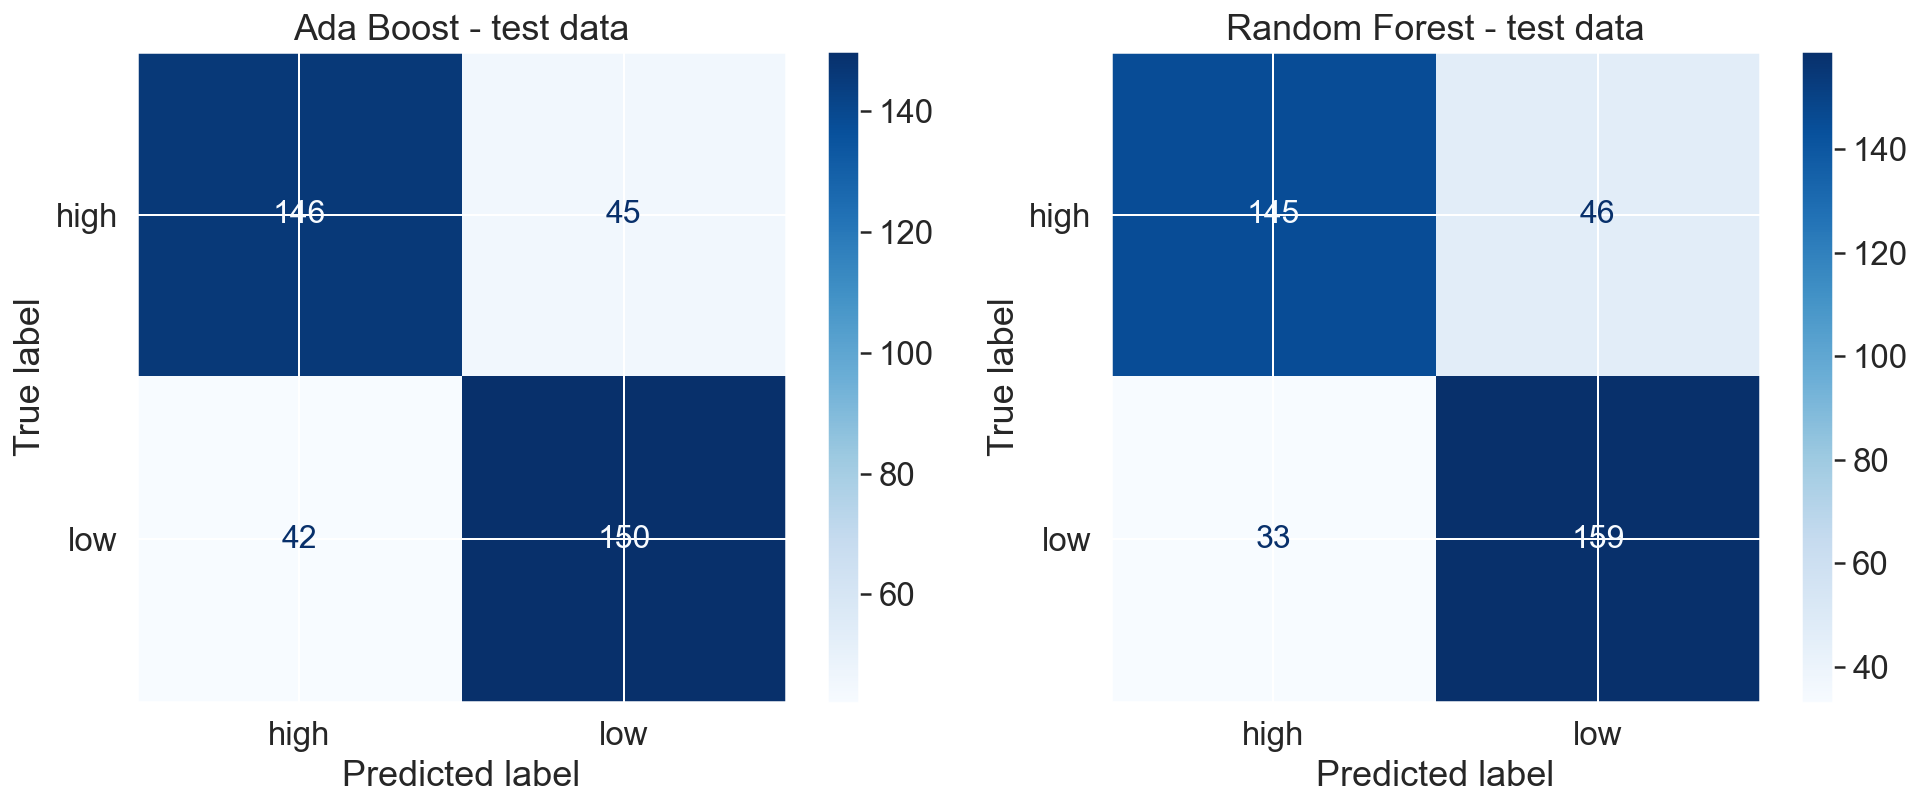

In [162]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
plot_confusion_matrix(ada_boost_gs.best_estimator_, X2_test, y_test, cmap='Blues', ax=ax[0])
plot_confusion_matrix(random_forest_gs.best_estimator_, X2_test, y_test, cmap='Blues', ax=ax[1])
ax[0].set_title('Ada Boost - test data')
ax[1].set_title('Random Forest - test data')
for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(16)
plt.show()

The confusion matrices are shown for both the Ada Boost and Random Forest classifiers on the test data (both models achieve a perfect score of 1.0 on the full training set i.e. they predict all of the high and low salaries correctly on the full training set, which is common with ensemble models).

- Ada Boost predicts 146 out of 191 high salaries correctly and 150 out of 192 low salaries correctly.
- Random Forest predicts 145 out of 191 high salaries correctly and 159 out of 192 low salaries correctly. 


- Ada Boost incorrectly predicts 45 high salaries as low and 42 low salaries as high.
- Random Forest incorrectly predicts 46 high salaries as low and 33 low salaries as high.

We would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. This means that we would like to minimize false positives for high salary i.e. when we predict high when it should be low but we do not mind so much about false negatives i.e. when we predict low when it should be high. This means we would like a lower number in the bottom left of the confusion matrix and we do not mind so much about the number in the top right. In other words, we would would prefer to maximize the precision score over the recall score for a high salary. On this basis, the Random Forest appears to be a better model as it has 33 false positives versus 42 in the Ada Boost model.

The precision and recall scores for all 8 classifiers are shown below. The Random Forest classifier has the highest precision score for high salaries at 0.8146.

In [163]:
# precision and recall scores for the 8 classifiers, ordered by precision
scores_df[['model_name','precision_high', 'recall_high']].sort_values('precision_high', ascending=False)

,model_name,precision_high,recall_high
5,Random Forest,0.814607,0.759162
0,Logistic regression,0.813187,0.774869
7,Gradient boosting,0.807229,0.701571
2,Bagging with KNN,0.782123,0.732984
4,Bagging with decision tree,0.777778,0.769634
6,Ada Boost,0.776596,0.764398
3,Decision tree,0.719577,0.712042
1,KNN,0.674208,0.780105


#### Precision-recall and ROC curves

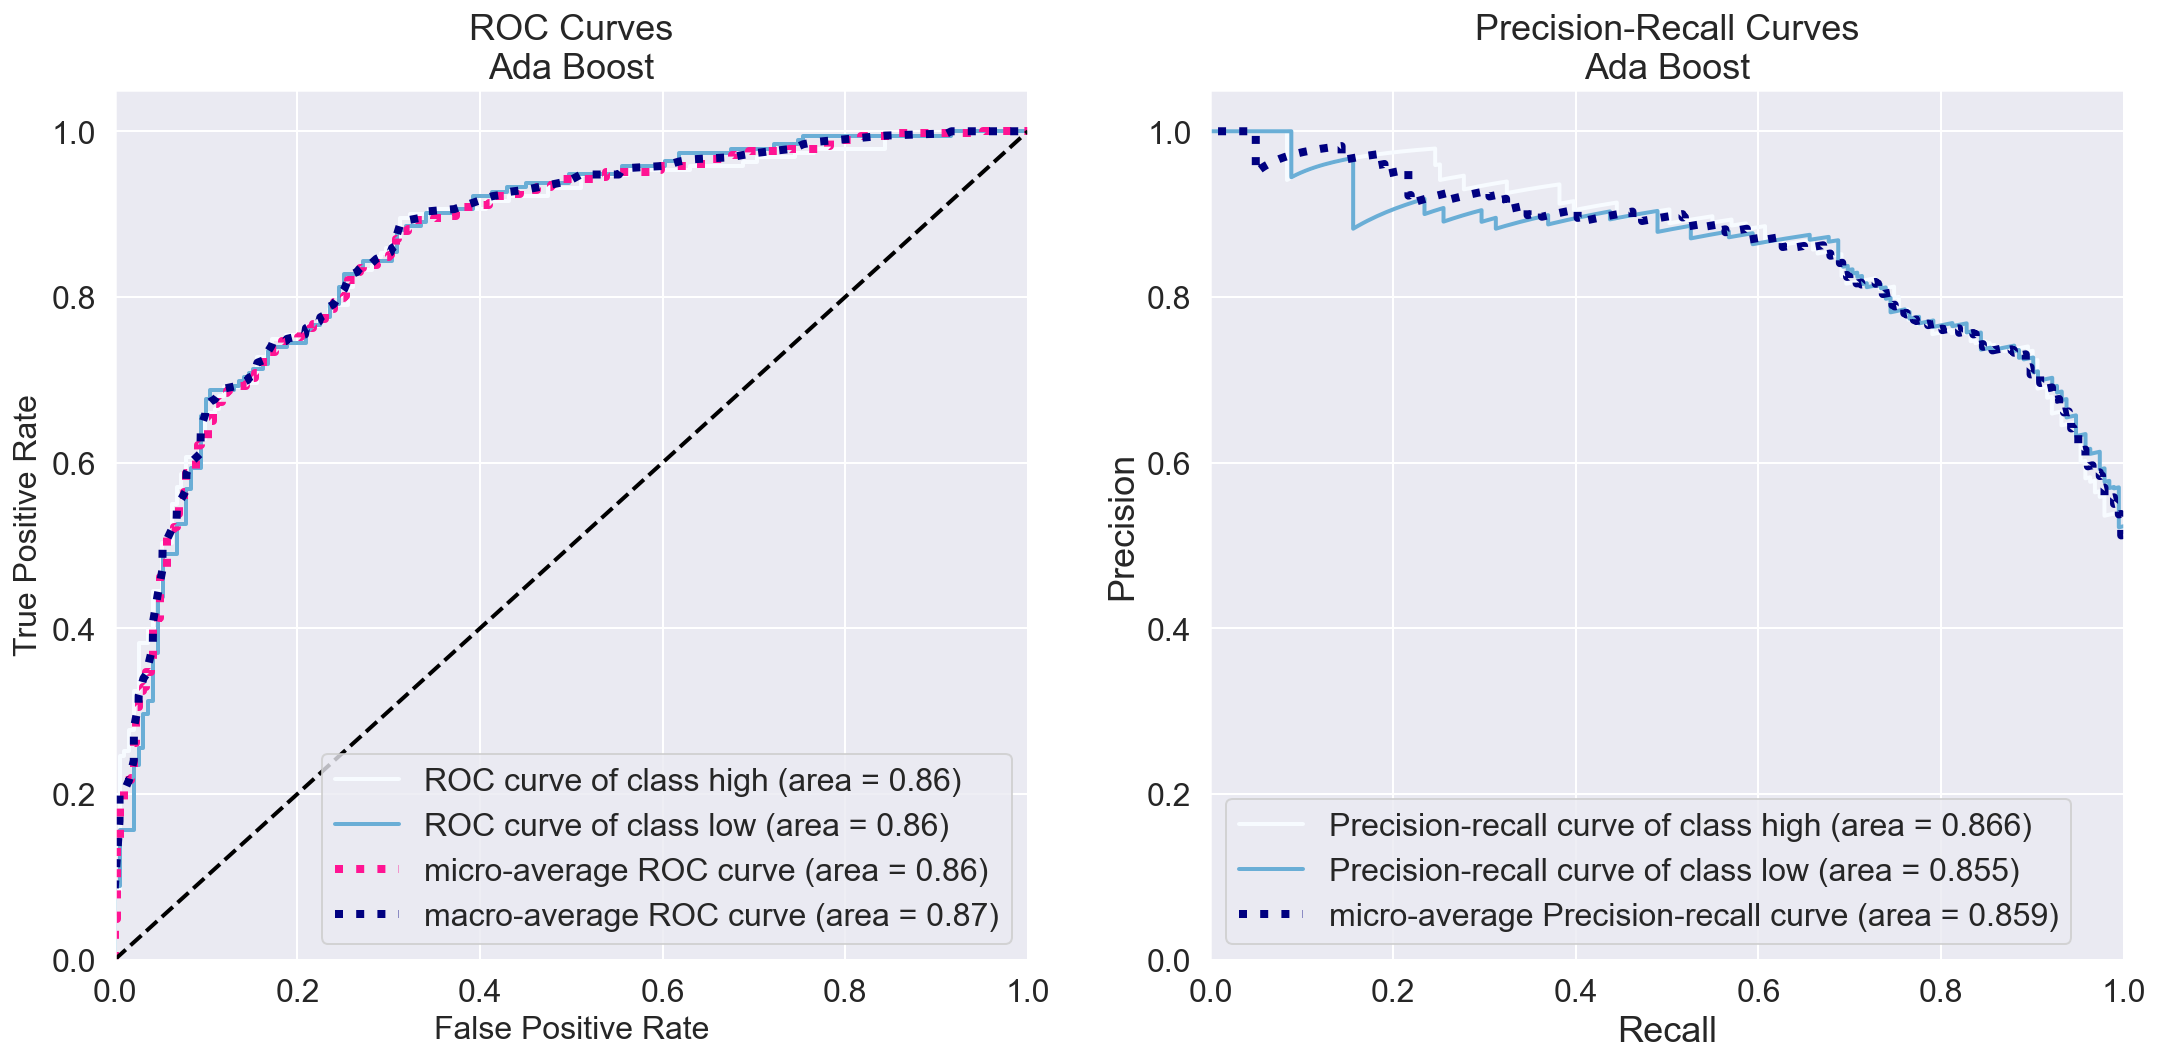

In [164]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 8))
skplt.metrics.plot_roc(y_test, ada_boost_gs.predict_proba(X2_test), plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[0])
skplt.metrics.plot_precision_recall(y_test, ada_boost_gs.predict_proba(X2_test), plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[1])
ax[0].set_title('ROC Curves\nAda Boost')
ax[1].set_title('Precision-Recall Curves\nAda Boost')
plt.show()

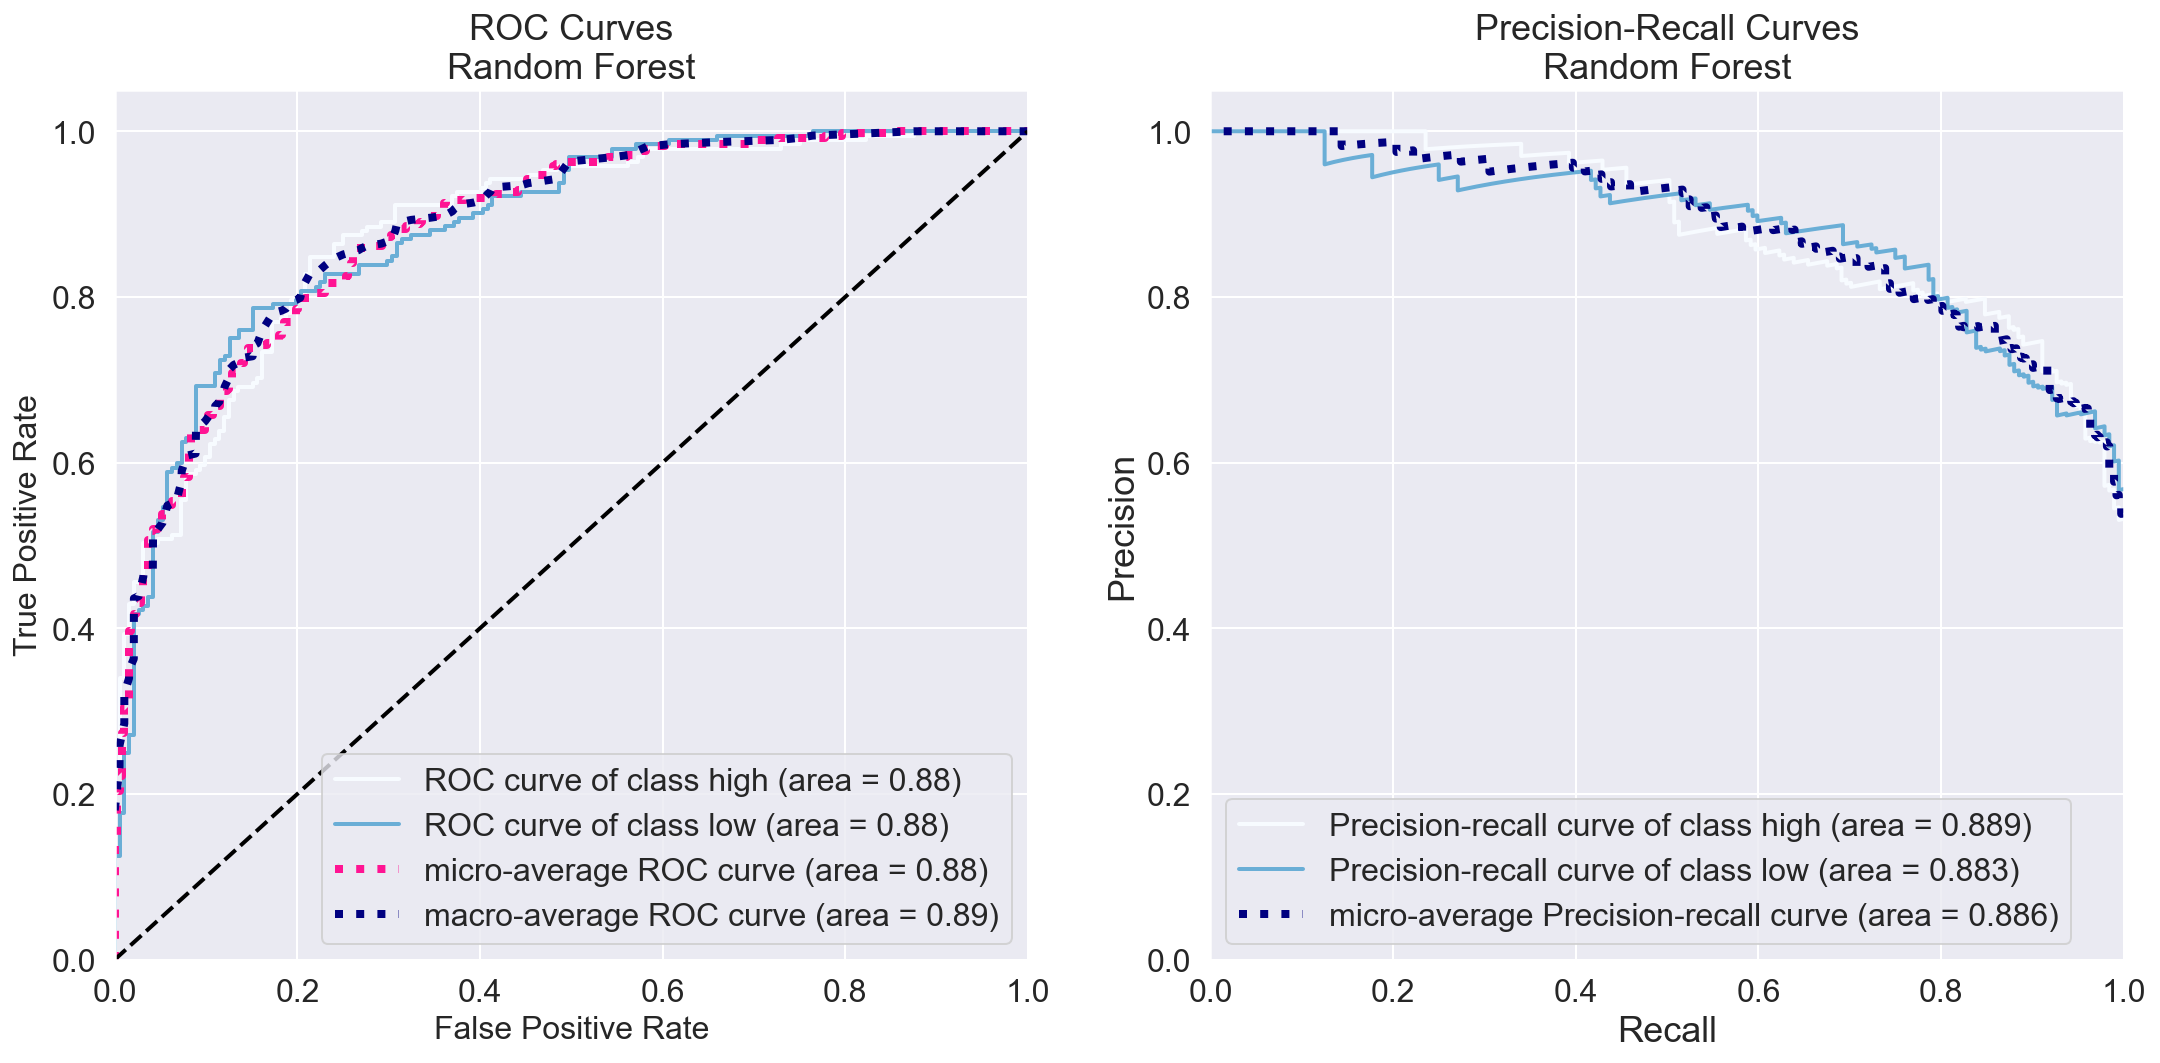

In [165]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 8))
skplt.metrics.plot_roc(y_test, random_forest_gs.predict_proba(X2_test), plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[0])
skplt.metrics.plot_precision_recall(y_test, random_forest_gs.predict_proba(X2_test), plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap='Blues', ax=ax[1])
ax[0].set_title('ROC Curves\nRandom Forest')
ax[1].set_title('Precision-Recall Curves\nRandom Forest')
plt.show()

The precision-recall curves show precision versus recall for different class assignment threshold values. If we wanted to increase precision, we could increase the class assignment threshold and the precision-recall curve would show us what the recall we could then reach at most would be.

The precision-recall curves and ROC curves have been plotted above for both Ada Boost and Random Forest. The area under the curves in both charts is higher for Random Forest.

#### Feature importances for Random Forest
The Random Forest classifier is the best classifier for this problem on several measures as shown above. Let's look at the feature importances from the model.

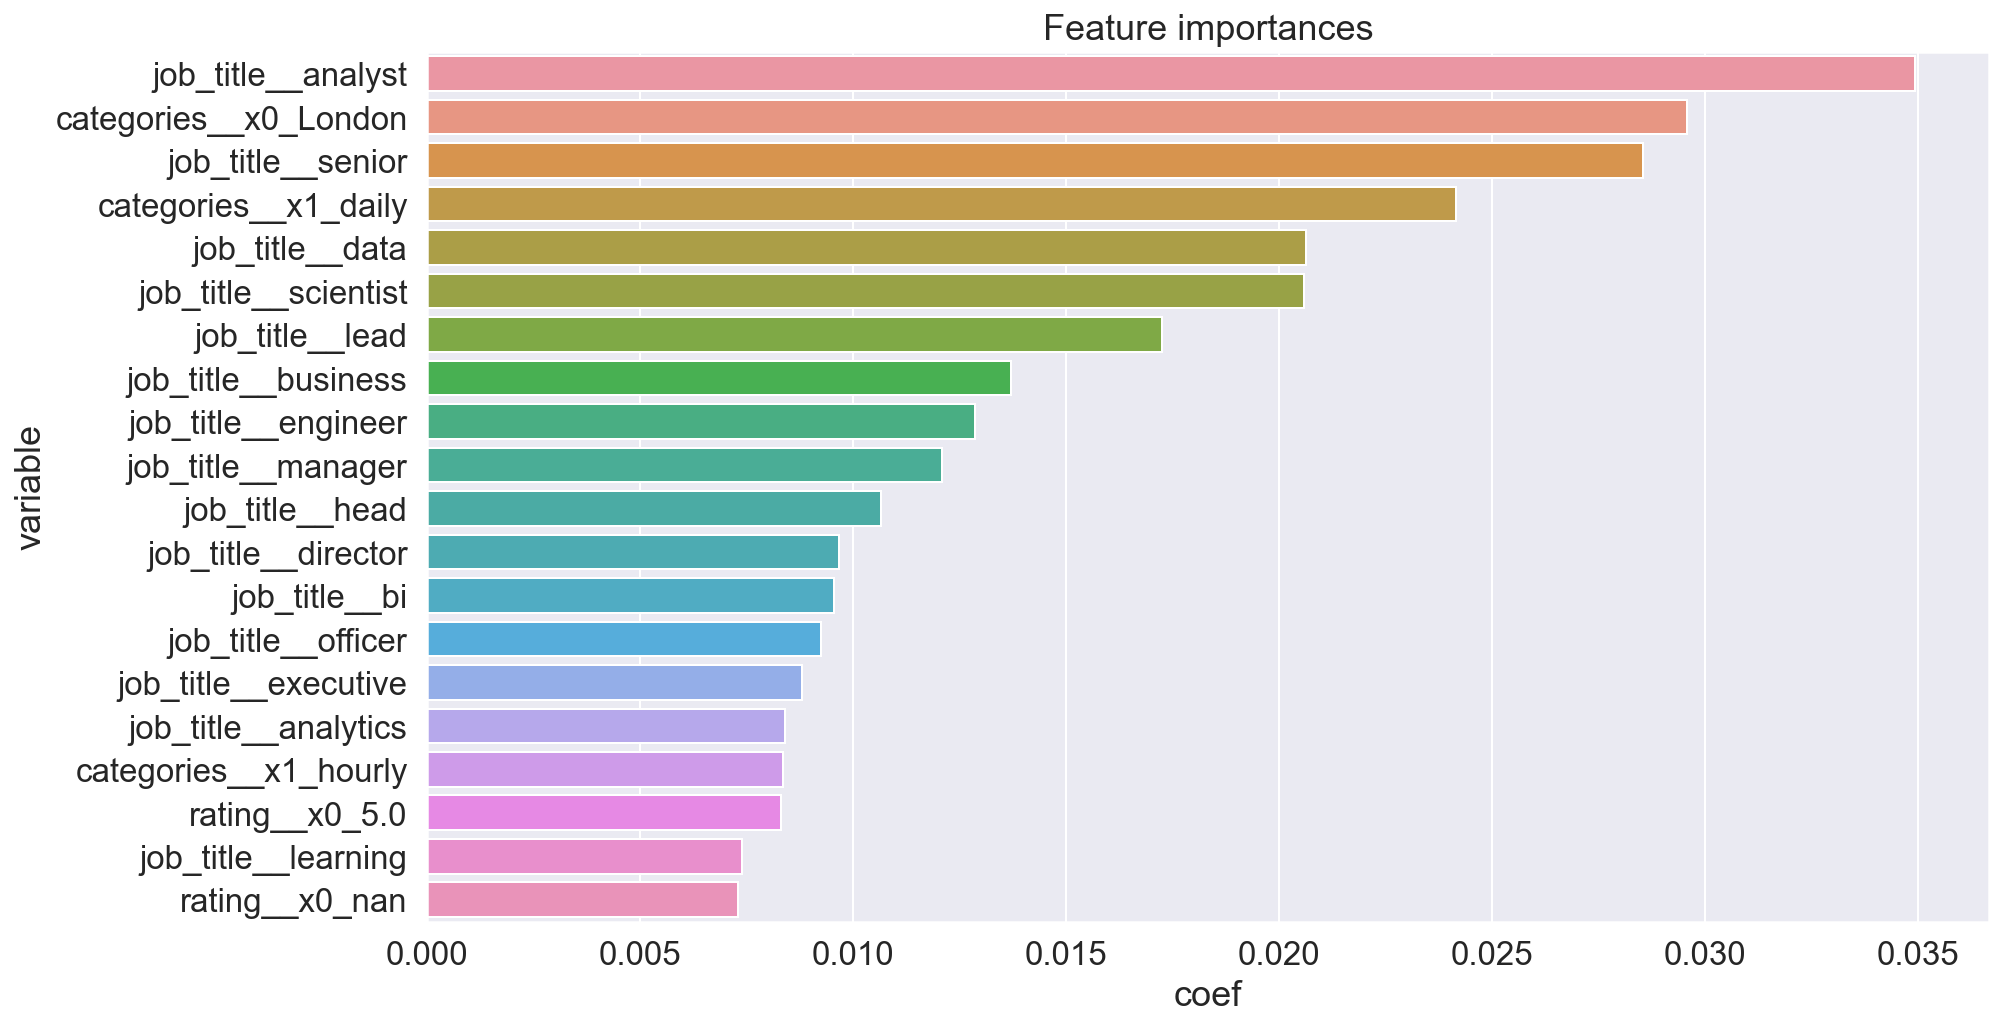

In [166]:
# plot feature importances for random forest
model = random_forest_gs.best_estimator_
df_coef = pd.DataFrame({'variable': col_trans_2.get_feature_names(), 
                        'coef': model.feature_importances_})

fig4, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_coef.sort_values('coef', ascending=False).head(20), x='coef', y='variable')
plt.title('Feature importances')
plt.show()

The bar chart above shows the top 20 feature importances for the Random Forest model. Words from the job title make up 15 out of the 20 most important features from the model for example: analyst, senior, scientist, data, lead. The region London is the second most important feature - this makes sense given that salaries tend to be higher in London. The salary being quoted as a daily rate is the fourth most important feature - again this makes sense given that daily contractor rates tend to be higher than an annual salary for a permanent role as contractors would not receive other benefits such as pension contributions, sick pay etc.

## Executive Summary

#### The question we would like to answer:
Which industry factors are most important in predicting the salary amounts for data related jobs?

##### Scope
Data related jobs (e.g. data scientist, data analyst, business intelligence) in the United Kingdom.

#### Data acquisition
The job data was acquired by web scraping from the website www.indeed.co.uk in January 2021. Searches were performed on different data related job titles in large cities in the UK. Information collected for each job listing included:
- Company
- Job title
- Job summary
- Location
- Salary
- Company rating

#### Data cleaning
Many job listings did not contain salary information and these were removed along with any duplicates. The remaining listings were cleaned to extract useful information for our analysis. For example:    

*Salary* - this is often quoted as a range and sometimes quoted annually, sometimes daily etc. Where a range is given, we assumed the mid point and all salaries were annualised to allow comparison. A new feature was created, salary type, containing information on how the salary was quoted i.e. annual, daily etc.   

*Location* - location is quoted inconsistently, sometimes as a town or a village, sometimes a county. Each location was assigned to its correct region within the UK to allow for modelling as a categorical variable (Greater London, South East, North West etc.)

After the data cleaning, we were left with 1,914 unique job listings.

#### Exploratory data analysis

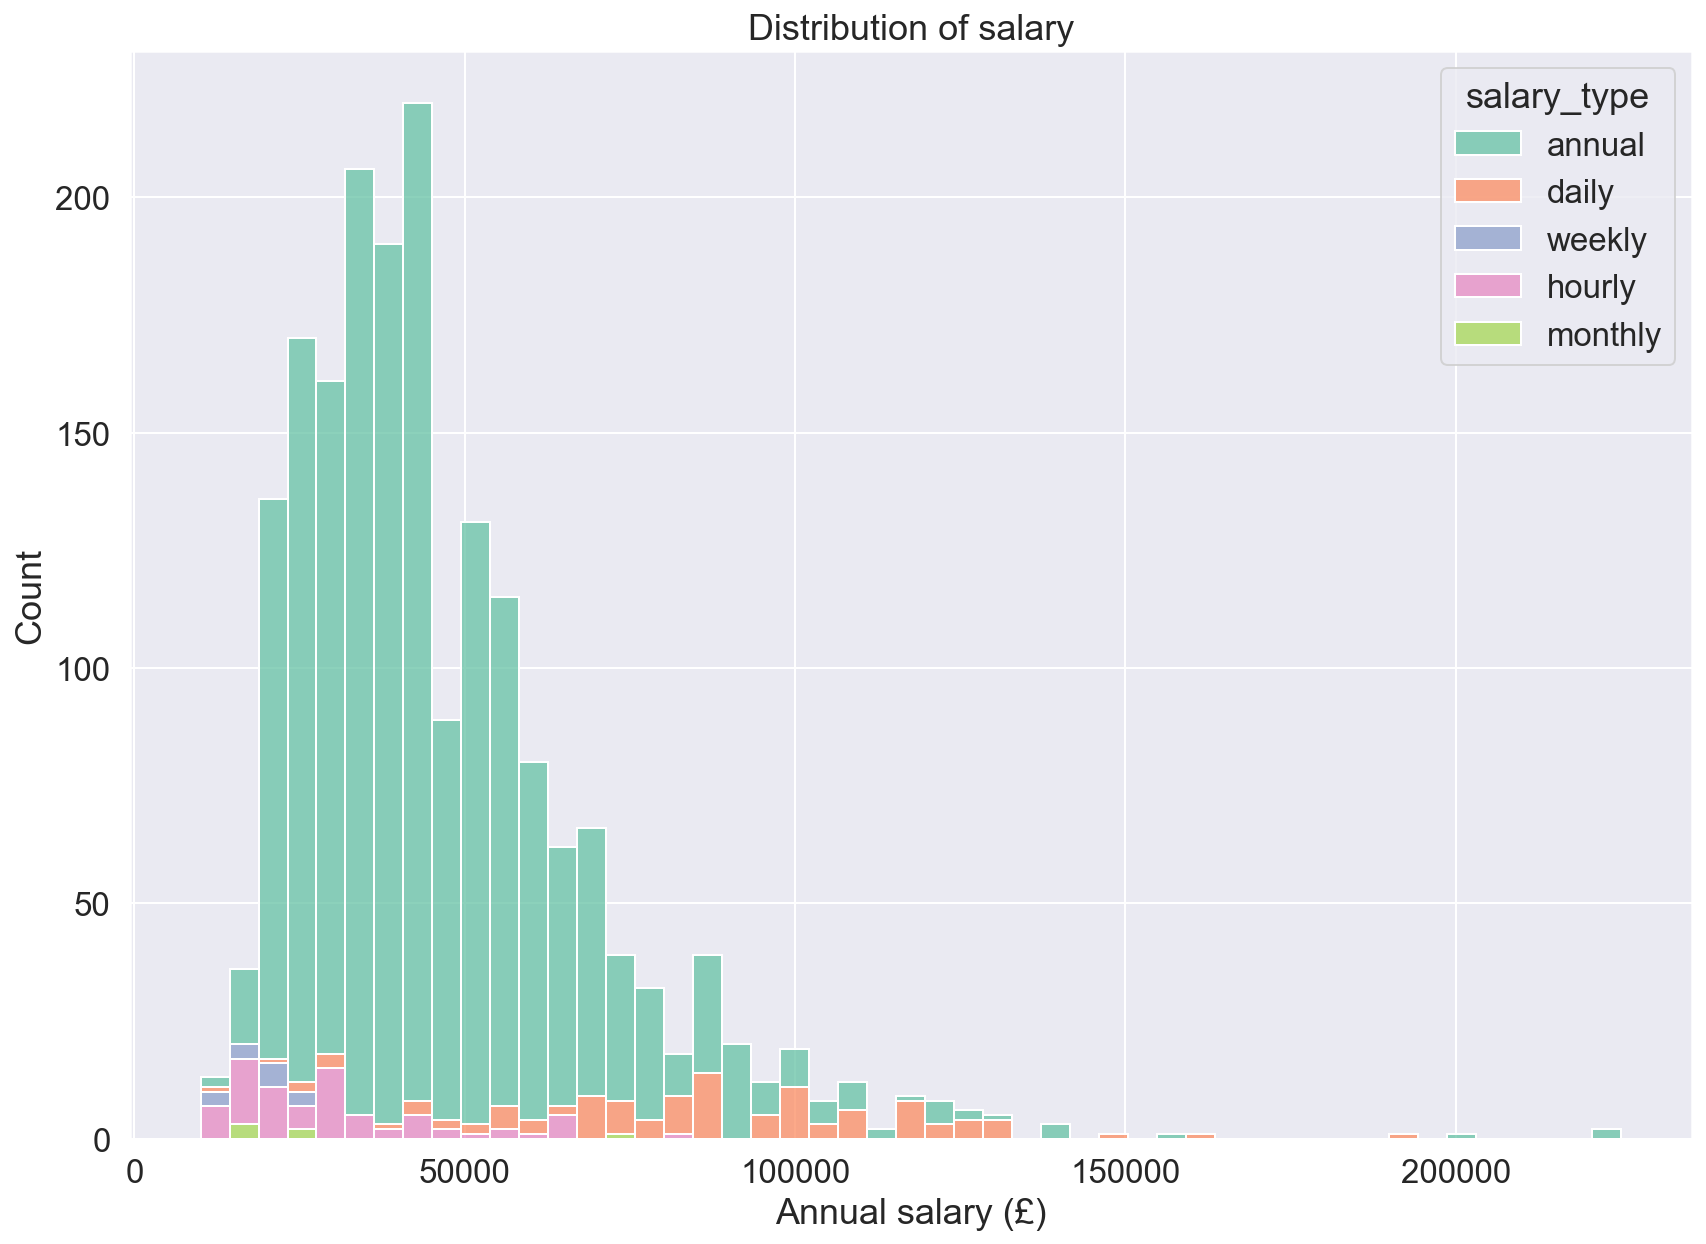

In [167]:
fig1

**Distribution of salary**   
The chart shows the distribution of the annual salary and includes information on how the salary is quoted in the job description e.g. is it quoted as an annual salary or as a daily rate (which I have converted to an annualized number for comparison). Most of the salaries are at the lower end with a few very high values. The median salary is £41,914.   

Unsurprisingly most of the salaries are quoted as annual salaries. It is interesting to see that the salaries which are quoted daily tend to be higher than the salaries which are quoted hourly, weekly or monthly. This implies that how the salary is quoted could be a good predictor of salary.

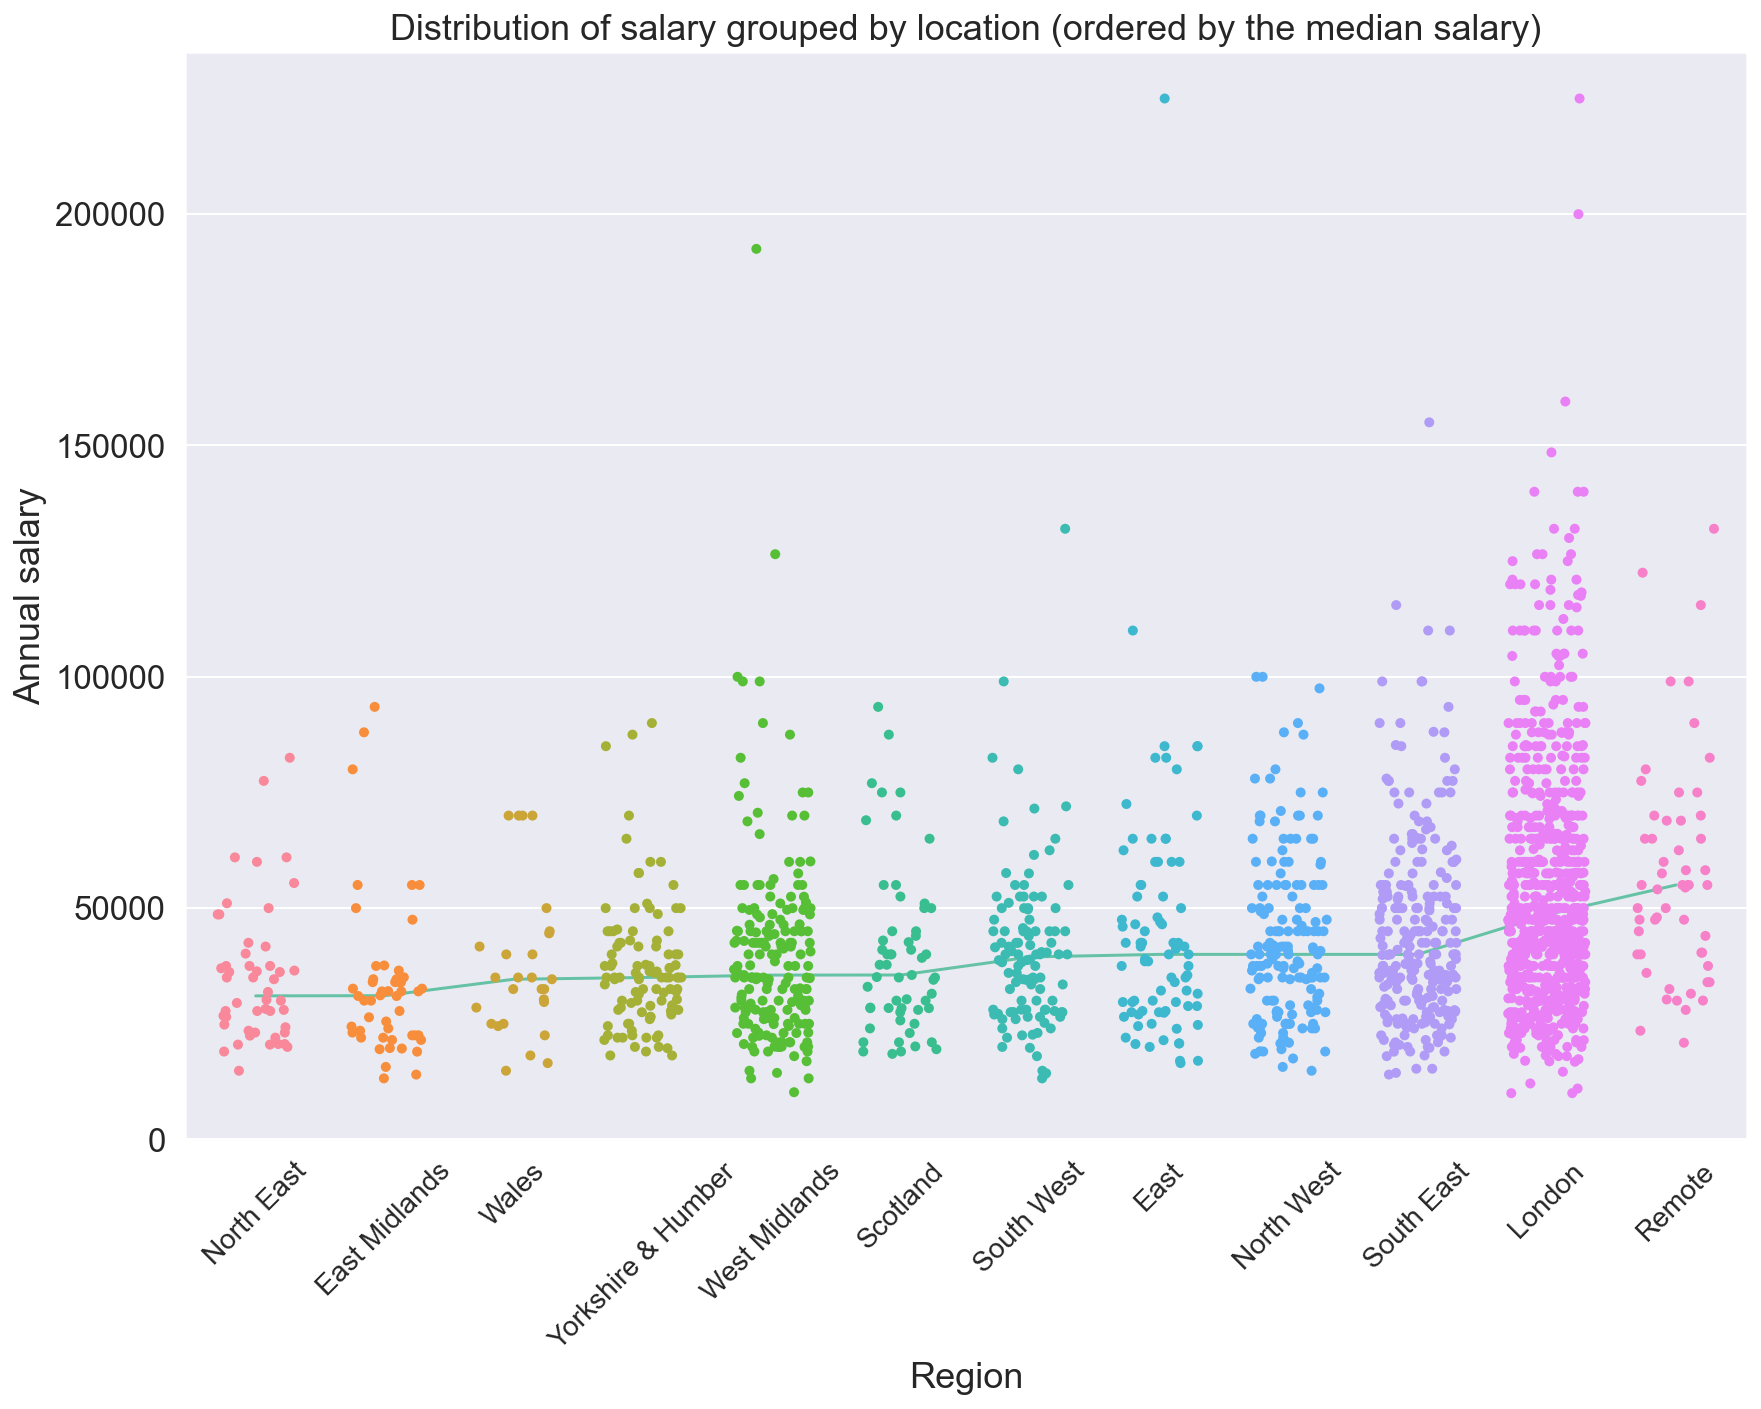

In [168]:
fig2

**Distribution of salary by location**  
The chart shows the distribution of salary by region, ordered by the median salary by region (shown by the line). Unsurprisingly London has the most data points and the second highest median salary. Jobs advertised as 'remote' have the highest median salary but there are not many data points in this category. It looks like the region should be a reasonable predictor of salary.

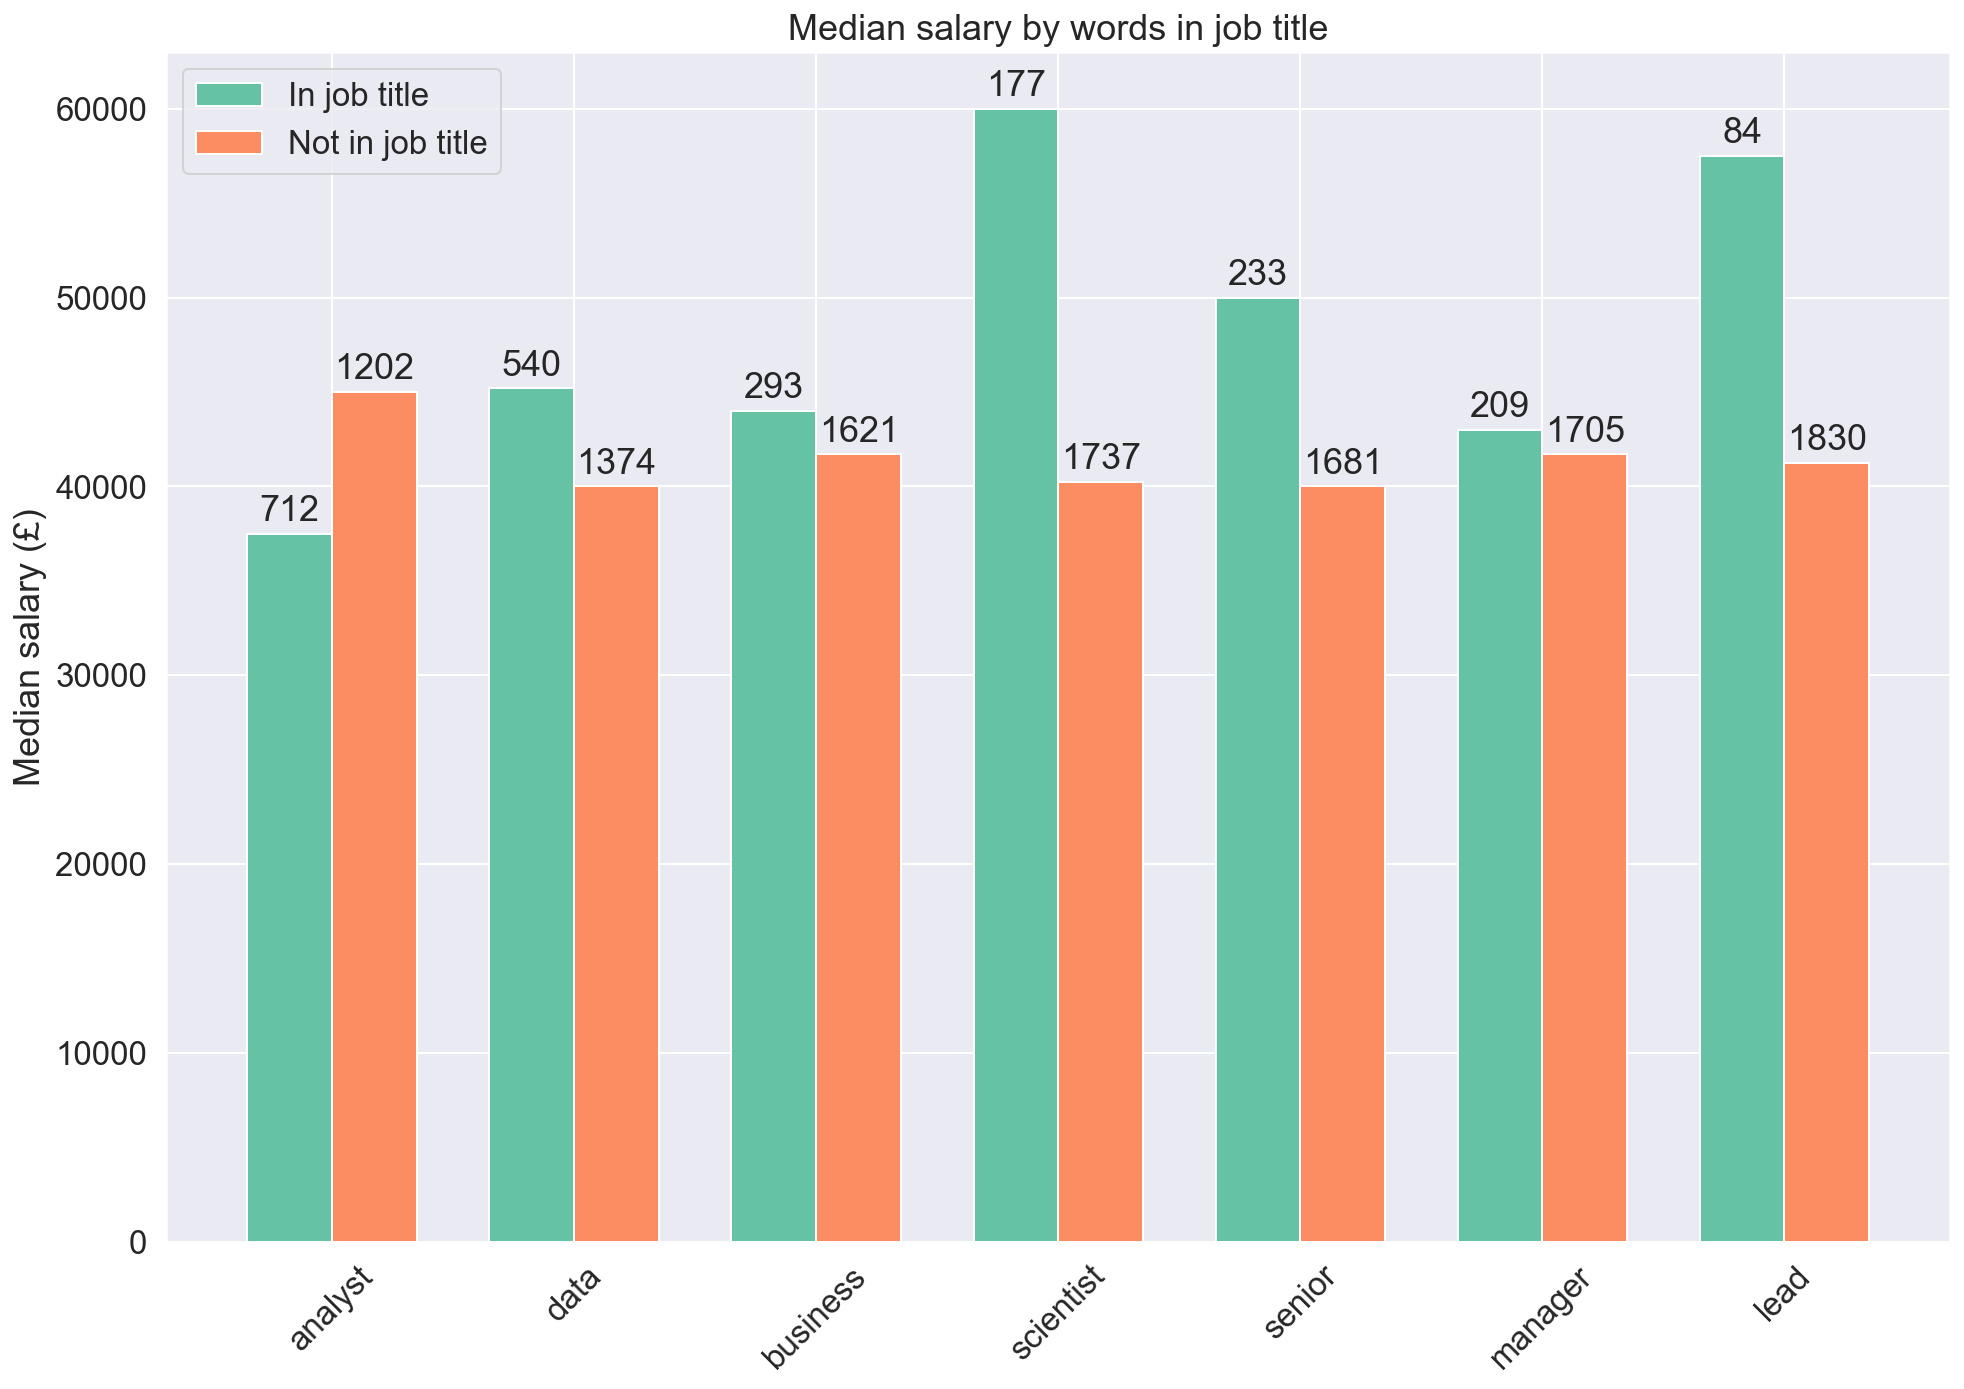

In [169]:
fig3

**Median salary by words in job title**    
The bar chart above looks at some of the most frequently occurring words in the job title and for each word, the median salary for the jobs which include that word in the title and the median salary for the jobs which do not. The numbers above the bars show the total number of job listings in each category.   

The word 'scientist' for example, shows a median salary of £60,000 for the 177 job listings which have 'scientist' in the title, and approximately £40,000 for the 1,737 job listings without 'scientist' in the title. This implies that having 'scientist' in the job title should be a good predictor of high salaries. Similarly 'senior' and 'lead' point to higher salaries whilst 'analyst' points to lower salaries.

#### Modelling
To answer the question about which industry factors are most important in predicting the salary amounts for data related jobs, we created a model which tries to predict whether a salary is 'high' or 'low' based on the following factors:
- Region
- Key words in the job title
- How the salary is quoted (e.g. annual, daily)
- Key words in the company name
- Company rating where available

A 'high' salary is defined as being above the median salary of £41,914 and a 'low' salary is below (splitting the salary in this way helps to remove noise from very high salaries).

Eight different models were tuned and tested. The model selected is able to predict correctly whether a salary is 'high' or 'low' based on the above factors **80%** of the time.

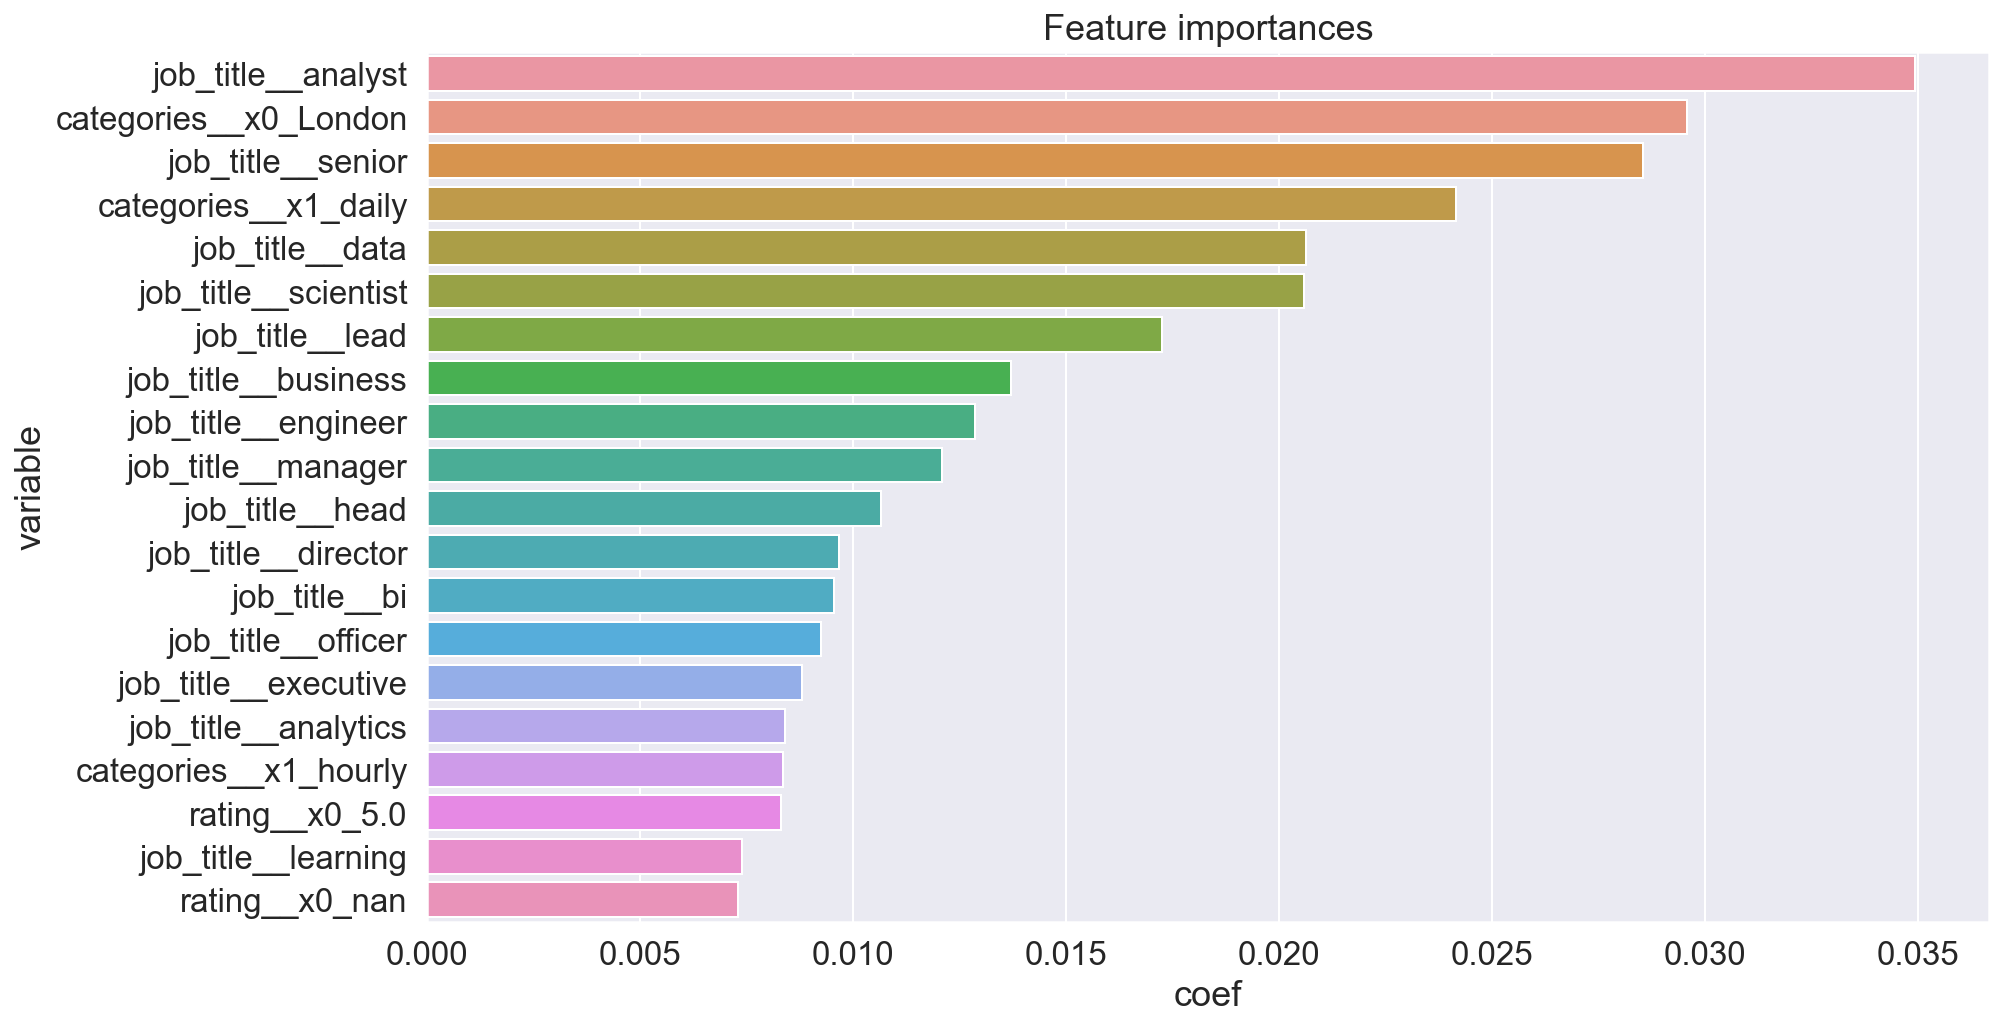

In [170]:
fig4

**The most important factors for predicting the salary**      
The bar chart above shows the top 20 feature importances from our model. Words from the job title make up 15 out of the 20 most important features from the model for example: analyst, senior, scientist, data, lead. The region London is the second most important feature - this makes sense given that salaries tend to be higher in London. The salary being quoted as a daily rate is the fourth most important feature - again this makes sense given that daily contractor rates tend to be higher than an annual salary for a permanent role as contractors would not receive other benefits such as pension contributions, sick pay etc.

#### Limitations
The data for this project was collected in January 2021. It does not take into account any trends in the job market over time and therefore the model will not reflect any changes over time e.g. a shift to remote working.   

The model has an accuracy score of 80% so in 20% of cases it does not predict correctly.